###  The code in this notebook can be used to replicate:
    1. Figure 2
    2. Extended Data Figures 2, 3
    3. Supplemental Data Figure 5


#### Decode pipeline output files (provided in https://drive.google.com/drive/folders/15YoTBTZh4MdtAqHbibkYieEqyLyFi5hb?usp=sharing or generated by rerunning pipeline https://github.com/SlavovLab/decode/tree/main/decode_pipeline) required: 

    1. "Supplemental_Data_2.SAAP_proteins.xlsx"
    2. "Supplemental_Data_3.SAAP_precursor_quant.xlsx"
    3. "Supplemental_Data_4.SAAP_reporter_quant.xlsx" 
    4. "Reference_proteins_ranked_Median_RAAS.xlsx" (in pipeline_output/analysis_dependencies)
    5. "refnorm_AARS_abund_dict.p" (in pipeline_output/analysis_dependencies)
    6. "Meta.csv" (in pipeline_output/Savitski/MSFragger_validation/)
    7. "Supplemental_Data_5.SAAP_SILAC_quant.xlsx"
    8. "Median_normalized_Replicate_data_all_celltypes.csv" (in pipeline_output/Savitski/AA_subs_pipeline)
    9. "combined_modified_peptide_label_quant.tsv" (in pipeline_output/Savitski/MSFragger_validation/Hepatocytes/Results)
        a. pipeline_output/Savitski/MSFragger_validation/Hepatocytes/ must be unzipped
    10. "2024-07-21-decoys-contam-human_MTP_Hepatocytes.fasta.fas" (in pipeline_output/Savitski/databases)
    11. "qMTP_dict_[celltype].p" for each cell type in Savitski et al. (in pipeline_output/Savitski/AA_subs_pipeline)
    12. "unique_CPTAC_SAAP_BP_list.txt" (in pipeline_output/analysis_dependencies)
    13. "MTP_quant_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    14. "Ion_validated_MTP_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    15. "Tonsil_SAAP_dict.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    16. "Tonsil_BP_dict.p" (in pipeline_output/HealthyTissues/AA_subs_pipeline)
    17. "codon_frequencies.tsv" (in pipeline_output/analysis_dependencies)
    18. "Allprot_normalized_abundance_dict.p" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    19. "blast_map_w_gene.xlsx" for each dataset (in pipeline_output/[dataset]/AA_subs_pipeline)
    
    

    
 




*** It is highly recommended to maintain the same directory structure as in the Google Drive ***


The code in this notebook is organized and labeled by references to figures in the manuscript. It is recommended to find and run the analyses of interest, rather than running the entire script at once. E.g. search page for "Figure 2a" to find code to replicate that data.

In [107]:
# read in packages needed

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from collections import Counter
import scipy as sp
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import os
import ast
from scipy.odr import Model, RealData, ODR
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import milkviz as mv
from matplotlib_venn import venn3
import zipfile
from glob import glob
import gzip
import tarfile
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

#### Setting directories and reading in data.

All of these directories should be updated by the user to reflect where their output data from the decode pipeline st stored.


In [5]:
proj_dir = '/Users/shiri/Library/CloudStorage/GoogleDrive-tsour.s@husky.neu.edu/My Drive/MS/SuppData/2024_Tsour/'

ccrcc_proj_dir = proj_dir+'pipeline_output/CCRCC/'
ccrcc_aa_subs_dir = ccrcc_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
ccrcc_sample_map = pd.read_excel(ccrcc_aa_subs_dir+'sample_map.xlsx')
ccrcc_samples = ['S'+str(i) for i in list(set(ccrcc_sample_map['TMT plex']))]

ucec_proj_dir = proj_dir+'pipeline_output/UCEC/'
ucec_aa_subs_dir = ucec_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
ucec_sample_map = pd.read_excel(ucec_aa_subs_dir+'sample_map.xlsx')
ucec_samples = ['S'+str(i) for i in list(set(ucec_sample_map['TMT plex']))]

brca_proj_dir = proj_dir+'pipeline_output/BRCA/'
brca_aa_subs_dir = brca_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
brca_sample_map = pd.read_excel(brca_aa_subs_dir+'sample_map.xlsx')
brca_samples = ['S'+str(i) for i in list(set(brca_sample_map['TMT plex']))]

luad_proj_dir = proj_dir+'pipeline_output/LUAD/'
luad_aa_subs_dir = luad_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
luad_sample_map = pd.read_excel(luad_aa_subs_dir+'sample_map.xlsx')
luad_samples = ['S'+str(i) for i in list(set(luad_sample_map['TMT plex']))]

pdac_proj_dir = proj_dir+'pipeline_output/PDAC/'
pdac_aa_subs_dir = pdac_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
pdac_sample_map = pd.read_excel(pdac_aa_subs_dir+'sample_map.xlsx')
pdac_samples = ['S'+str(i) for i in list(set(pdac_sample_map['TMT plex']))]

lscc_proj_dir = proj_dir+'pipeline_output/LSCC/'
lscc_aa_subs_dir = lscc_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
lscc_sample_map = pd.read_excel(lscc_aa_subs_dir+'sample_map.xlsx')
lscc_samples = ['S'+str(i) for i in list(set(lscc_sample_map['TMT plex']))]

wang_proj_dir = proj_dir+'pipeline_output/HealthyTissues/'
wang_data_dir = wang_proj_dir+'AA_subs_pipeline/'# aa_subs_dir is the output folder
wang_samples = open(wang_data_dir+'proteomic_tissue_list.txt', 'r').read().split('\n')
wang_samples = [x for x in wang_samples if x!='rectum']

# lists used to quickly index dataset-specific sample maps (e.g.) from just the dataset name
datasets = ['CCRCC', 'UCEC', 'BRCA', 'LUAD', 'PDAC', 'LSCC', 'Healthy']
data_dir_list = [ccrcc_aa_subs_dir, ucec_aa_subs_dir, brca_aa_subs_dir, luad_aa_subs_dir, pdac_aa_subs_dir, lscc_aa_subs_dir, wang_data_dir]
samples_list = [ccrcc_samples, ucec_samples, brca_samples, luad_samples, pdac_samples, lscc_samples, wang_samples]
sample_map_list = [ccrcc_sample_map, ucec_sample_map, brca_sample_map, luad_sample_map, pdac_sample_map, lscc_sample_map]
proj_dir_list = [ccrcc_proj_dir, ucec_proj_dir, brca_proj_dir, luad_proj_dir, pdac_proj_dir, lscc_proj_dir, wang_proj_dir]

dependencies_dir = proj_dir+'pipeline_output/analysis_dependencies/'
outdir = 'figures_testing/' # output directory where to save figures

In [6]:
class GridShader():
    """
    function used to create alternating vertical gray and white background in plots
    """
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks, [xlim[-1]]]))

        start = [x-0.5 for x in locs[1-int(self.sf)::2]]
        end = [x-0.5 for x in locs[2-int(self.sf)::2]]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))


def bihist(y1, y2, nbins=10, h=None):
    '''
    Function used to create violin plots as bihistograms with no smoothing.
    h is an axis handle. If not present, a new figure is created.
    '''
    if h is None: h = plt.figure().add_subplot(111)
    ymin = np.floor(np.minimum(min(y1), min(y2)))
    ymax = np.ceil(np.maximum(max(y1), max(y2)))
    bins = np.linspace(ymin, ymax, nbins)
    n1, bins1, patch1 = h.hist(y1, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    n2, bins2, patch2 = h.hist(y2, bins, orientation='horizontal', color='#AAAAAA', edgecolor=None, linewidth=0,rwidth=1)
    # set xmax:
    xmax = 0
    for i in patch1:
        i.set_edgecolor(None)
        width = i.get_width()
        if width > xmax: xmax = width
    # invert second histogram and set xmin:
    xmin = 0
    for i in patch2:
        i.set_edgecolor(None)
        width = i.get_width()
        width = -width
        i.set_width(width)
        if width < xmin: xmin = width
    h.set_xlim(xmin*1.1, xmax*1.1)          
    h.figure.canvas.draw()

# Figure 2 - RAAS

#### Incl. Extended Data Figures 2, 3.

Read in dataframes generated for Supplemental Data Figures.
All data in these dataframes was taken from the dictionaries output from the decode pipeline

In [24]:
filt_saap_df = pd.read_excel(proj_dir+'Supplemental_Data_2.SAAP_proteins.xlsx', index_col=0)
filt_prec_quant_df = pd.read_excel(proj_dir+'Supplemental_Data_3.SAAP_precursor_quant.xlsx', index_col=0)
filt_reporter_quant_df = pd.read_excel(proj_dir+'Supplemental_Data_4.SAAP_reporter_quant.xlsx', index_col=0)

filt_saap_df_list = [filt_saap_df.loc[filt_saap_df['Dataset']==ds] for ds in datasets]
reporter_quant_df_list = [filt_reporter_quant_df.loc[filt_reporter_quant_df['Dataset']==ds] for ds in datasets[:-1]]
prec_quant_df_list = [filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds] for ds in datasets]

### Figure 2b. sample-level RAAS distribution 

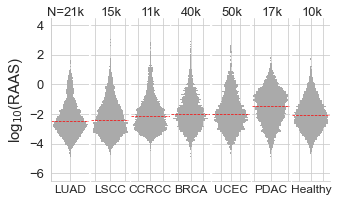

In [10]:
# sample/reporter ion level RAAS distributions for each dataset 

sns.set_style('whitegrid')
fig,axes = plt.subplots(1,len(datasets),figsize=(5,3), sharey=True)
plt.subplots_adjust(wspace=0.05)

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

medians = [np.nanmedian(reporter_quant_df_list[i]['RAAS'].values) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=12)
    if ds!='Healthy':
        ratio_data = [x for x in reporter_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    else:
        ratio_data = [x for x in prec_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=100,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.1,1.01), xycoords='axes fraction', fontsize=13)
        axes[ax_idx].annotate(str(np.round(len(ratio_data), -3))[0:2]+'k', (0.32,1.01), xycoords='axes fraction', fontsize=13)
        
    else:
        axes[ax_idx].annotate(str(np.round(len(ratio_data), -3))[0:2]+'k', (0.25,1.01), xycoords='axes fraction', fontsize=13)
        
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)
axes[0].set_yticks([-6,-4,-2,0,2,4]);

plt.savefig(outdir+'Sample_level_RAAS_allDS.pdf', bbox_inches='tight')

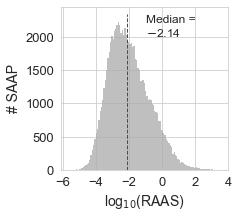

In [11]:
# fig 2b. sample-level RAAS distribution - all datasets in one distribution

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))

ratios = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        ratio_data = [x for x in reporter_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    else:
        ratio_data = [x for x in prec_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    ratios = ratios + ratio_data
    
sns.histplot(ratios, color='#AAAAAA', linewidth=0)
plt.plot((np.median(ratios), np.median(ratios)),(plt.ylim()), '--r', linewidth=1)
ax.annotate('Median =\n$-$'+str(np.abs(np.round(np.median(ratios), 2))), (-1,2000), fontsize=12)
ax.set_ylabel(r'# SAAP', fontsize=14)
ax.set_xlabel(r'log$_{10}$(RAAS)', fontsize=14)
ax.tick_params('both',labelsize=13)
ax.set_xticks([-6,-4,-2,0,2,4]);

plt.savefig(outdir+'Sample_level_RAAS_allDS_onehistplot.pdf', bbox_inches='tight')

### Extended Data Figure 3a. TMT-level RAAS distribution

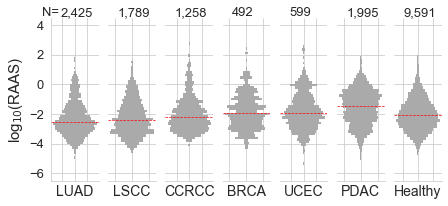

In [12]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)

sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

medians = [np.nanmedian(prec_quant_df_list[i]['RAAS'].values) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    ratio_data = [x for x in prec_quant_df_list[i]['RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=50,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.2,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].annotate('{:,}'.format((len(ratio_data))), (0.2,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)

plt.savefig(outdir+'TMT_level_RAAS_allDS_nogrid.pdf', bbox_inches='tight')

### Extended Data Figure 3c. Sample median RAAS distributions

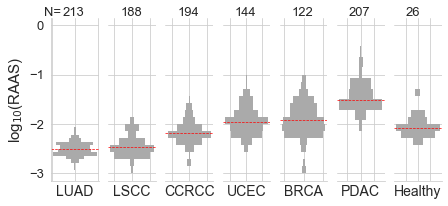

In [13]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)
#plt.ylim([-3.5,0])
sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

sample_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        samples = list(set(reporter_quant_df['Sample name'].values))
        sample_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['Sample name']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        samples = list(set(prec_quant_df['TMT/Tissue'].values))
        sample_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['TMT/Tissue']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
        
medians = [np.nanmedian(sample_median_values_list[i]) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    ratio_data = [x for x in sample_median_values_list[i] if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=15,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.15,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].annotate('{:,}'.format((len(ratio_data))), (0.25,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)

#plt.annotate('Cancer and normal adjacent tissue', (0.14,0.97), xycoords='figure fraction')
#plt.show()
plt.savefig(outdir+'Sample_median_RAAS_allDS.pdf', bbox_inches='tight')

### Extended data figure 3b. Median RAAS for all unique SAAP

/Users/shiri/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


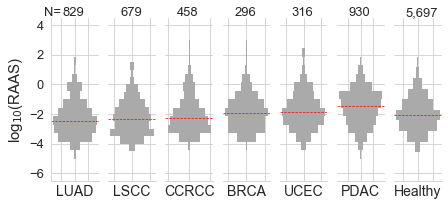

In [14]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)
sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)

saap_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        saap = list(set(reporter_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        saap = list(set(prec_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
        
medians = [np.nanmedian(saap_median_values_list[i]) for i in range(len(datasets)-1)]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    ratio_data = [x for x in saap_median_values_list[i] if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=15,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.15,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].annotate('{:,}'.format((len(ratio_data))), (0.25,1.01), xycoords='axes fraction', fontsize=13)
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$(RAAS)', fontsize=15)
axes[0].tick_params('y',labelsize=13)

plt.savefig(outdir+'SAAP_median_RAAS_allDS.pdf', bbox_inches='tight')

### Extended data figure 3d. Medians of extended 3a-c.

/Users/shiri/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


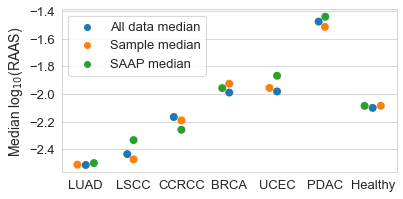

In [15]:
all_medians = [np.nanmedian(reporter_quant_df_list[i]['RAAS'].values) for i in range(len(datasets)-1)]
all_medians.append(np.nanmedian(prec_quant_df_list[-1]['RAAS'].values))
sample_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        samples = list(set(reporter_quant_df['Sample name'].values))
        sample_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['Sample name']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        samples = list(set(prec_quant_df['TMT/Tissue'].values))
        sample_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['TMT/Tissue']==s, 'RAAS'].values) for s in samples]
        sample_median_values_list.append(sample_medians)
sample_medians = [np.nanmedian(sample_median_values_list[i]) for i in range(len(datasets))]

saap_median_values_list = []
for i,ds in enumerate(datasets):
    if ds!='Healthy':
        reporter_quant_df = reporter_quant_df_list[i]
        saap = list(set(reporter_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(reporter_quant_df.loc[reporter_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
    else:
        prec_quant_df = prec_quant_df_list[i]
        saap = list(set(prec_quant_df['SAAP'].values))
        saap_medians = [np.nanmedian(prec_quant_df.loc[prec_quant_df['SAAP']==s, 'RAAS'].values) for s in saap]
        saap_median_values_list.append(saap_medians)
        
saap_medians = [np.nanmedian(saap_median_values_list[i]) for i in range(len(datasets))]

plot_rows = []
plot_cols = ['Dataset', 'Median RAAS', 'Median type']
for m, median in enumerate(all_medians):
    plot_rows.append([datasets[m], median, 'All data median'])
for m, median in enumerate(sample_medians):
    plot_rows.append([datasets[m], median, 'Sample median'])
for m, median in enumerate(saap_medians):
    plot_rows.append([datasets[m], median, 'SAAP median'])
    
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)    

fig,ax = plt.subplots(figsize=(6,3))
sns.swarmplot(data=plot_df, x='Dataset', y='Median RAAS', hue='Median type', s=8,
              order=['LUAD','LSCC','CCRCC','BRCA','UCEC','PDAC','Healthy'])
plt.legend(title='', fontsize=13)
ax.tick_params('both', labelsize=13)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('')
plt.savefig(outdir+'RAAS_distribution_median_comparison_swarmplot.pdf', bbox_inches='tight')

### Figure 2g. Proteins with high RAAS

In [16]:
# this dataframe was generated separately using the results from the protein set enrichment analysis 

ref_prot_df = pd.read_excel(dependencies_dir+'Reference_proteins_ranked_Median_RAAS.xlsx', index_col=0)

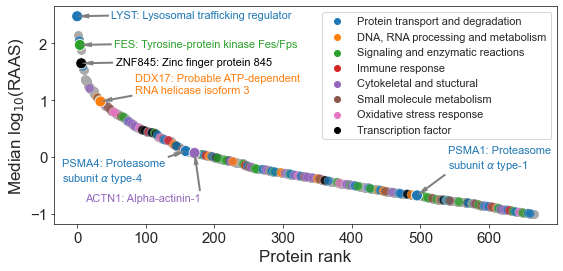

In [17]:
sns.set_style('ticks')
fig,ax = plt.subplots(figsize=(9,4))

hue_order=['Protein transport and degradation','DNA, RNA processing and metabolism','Signaling and enzymatic reactions', 'Immune response', 'Cytokeletal and stuctural', 'Small molecule metabolism', 'Oxidative stress response', 'Transcription factor']
nonpath_rows = [i for i,row in ref_prot_df.iterrows() if row['Median RAAS']>-1 and row['Pathway group'] not in hue_order]

sns.scatterplot(data=ref_prot_df.loc[nonpath_rows], x='Rank', y='Median RAAS', color='#aaaaaa', s=80, linewidth=0, alpha=1)
sns.scatterplot(data=ref_prot_df.loc[(ref_prot_df['Median RAAS']>-1) & (ref_prot_df['Pathway group']!='')], x='Rank', y='Median RAAS', s=80, hue='Pathway group', linewidth=0.2,alpha=0.8,
                palette=colors[0:7]+['black'], hue_order=hue_order)

ax.tick_params('both', labelsize=15)
plt.xlabel('Protein rank', fontsize=17)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=17)
plt.legend(title='', fontsize=11)

ranks2plot = [0,495,4,34,171, 158, 6]
sns.scatterplot(data=ref_prot_df.loc[ref_prot_df['Rank'].isin(ranks2plot)], x='Rank', y='Median RAAS', s=120, hue='Pathway group', linewidth=0.8, alpha=1,
                palette=colors[0:7]+['black'], hue_order=hue_order)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[:8], labels=labels[:8], fontsize=11, bbox_to_anchor=(1,1))

texts2plot = ['LYST: Lysosomal trafficking regulator', 'PSMA1: Proteasome\n'+r'subunit $\alpha$ type-1',
             'FES: Tyrosine-protein kinase Fes/Fps', 'DDX17: Probable ATP-dependent\nRNA helicase isoform 3',
             'ACTN1: Alpha-actinin-1', 'PSMA4: Proteasome\n'+r'subunit $\alpha$ type-4', 
             'ZNF845: Zinc finger protein 845']
colors2plot = [colors[0], colors[0], colors[2], colors[1], colors[4], colors[0], 'black']

for i,rank in enumerate(ranks2plot):
    txt = texts2plot[i]
    y = ref_prot_df.loc[ref_prot_df['Rank']==rank,'Median RAAS']
    if 'Proteasome' not in txt and 'actin' not in txt and 'DDX' not in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank+50,y+0.1), xycoords='data', textcoords='data', va='top',
                arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    elif 'DDX' in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank+50,y+0.3), xycoords='data', textcoords='data', va='center',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    elif 'type-4' in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank-180,y-0.6), xycoords='data', textcoords='data', va='bottom',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    elif 'type-1' in txt:
        ax.annotate(txt, xy=(rank,y), xytext=(rank+45,y+0.4), xycoords='data', textcoords='data', va='bottom',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
    else:
        ax.annotate(txt, xy=(rank,y), xytext=(rank-160,y-0.8), xycoords='data', textcoords='data', va='center',
        arrowprops=dict(facecolor='gray', headwidth=5,width=2, linewidth=0), color=colors2plot[i], fontsize=11)
plt.savefig(outdir+'Protein_group_RAAS_rank_plot.pdf', bbox_inches='tight')


### Figure 2d. Peptide precursor ion abundance relative to shared peptide 


In [28]:
def raas2bin(raas):
    """ function to bin RAAS values for plotting"""
    if raas<-3:
        raas_bin = '[-$\infty$,-3]'
    elif raas<-2:
        raas_bin = '(-3,-2]'
    elif raas<-1:
        raas_bin = '(-2,-1]'
    elif raas<0:
        raas_bin = '(-1,0]'
    elif raas<1:
        raas_bin = '(0,1]'
    else:
        raas_bin = '(1,$\infty$)'
    return(raas_bin)


# add RAAS bin and ratios of SAAP and BP to shared peptide abundance
filt_prec_quant_df['RAAS_bin'] = filt_prec_quant_df['RAAS'].apply(raas2bin)
filt_prec_quant_df['MTP/SP'] = np.nan
filt_prec_quant_df['BP/SP'] = np.nan

for i,row in filt_prec_quant_df.iterrows():
    mtp = row['SAAP abundance']
    bp = row['BP abundance']
    shared_p = row['Mean shared peptide precursor intensity']
    filt_prec_quant_df.loc[i,'MTP/SP'] = mtp/shared_p
    filt_prec_quant_df.loc[i, 'BP/SP'] = bp/shared_p

raas_bins = ['[-$\infty$,-3]', '(-3,-2]','(-2,-1]','(-1,0]','(0,1]','(1,$\infty$)']

/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/Users/shiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


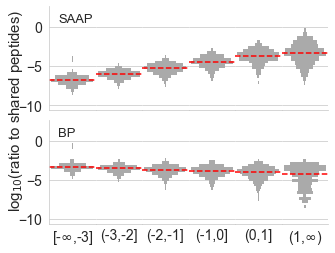

In [29]:
# plot distributions of abundance of SAAP/BP to shared peptide abundance as a function of RAAS

fig,axi = plt.subplots(2, len(raas_bins), figsize=(5,4), sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.1)
sns.set_style('whitegrid')
for j, axes in enumerate(axi):
    for i,rbin in enumerate(raas_bins):
        ax = axes[i]
        if j==1:
            ax.set_xlabel(rbin, fontsize=14);
        ax.set_xticks([])
        if j==0:
            rbin_data = [np.log10(x) for x in filt_prec_quant_df.loc[filt_prec_quant_df['RAAS_bin']==rbin, 'MTP/SP'].values]
            peptype = 'SAAP'
        else:
            rbin_data = [np.log10(x) for x in filt_prec_quant_df.loc[filt_prec_quant_df['RAAS_bin']==rbin, 'BP/SP'].values]
            peptype = 'BP'

        rbin_data = [x for x in rbin_data if (~np.isnan(x)) and (~np.isinf(x))]
        bihist(rbin_data, rbin_data, nbins=20, h=ax)
        if i>0:
            ax.spines['left'].set_visible(False)
           # ax.set_yticks([])
        ax.spines['top'].set_visible(False)

        median_abund = np.nanmedian(rbin_data)
       # print(rbin, median_abund)
        ax.plot(ax.get_xlim(), (median_abund, median_abund), '--r')

        if ax==axes[-1]:
            ax.spines['right'].set_visible(False)
        #ax.set_ylim([-4.5,4])

    axes[0].tick_params('y', labelsize=14)
    #axes[0].set_yticks([-4,-2,0,2,4], labels=[-4,-2,0,2,'']);
    axes[0].annotate(peptype, (0.2, 0.85), xycoords='axes fraction', fontsize=13)   
axi[1][0].annotate('log$_{10}$(ratio to shared peptides)', (-0.9,1.1), xycoords='axes fraction', fontsize=15, 
                   rotation='vertical', va='center')
    
plt.savefig(outdir+'SAAP_BP_SP_ratio_bihist_RAASbins_allDS.pdf', bbox_inches='tight')    

### Extended data figure 2i: Correlations of SAAP|BP to SP across all samples

In [35]:
# get a dataframe of the correlations of SAAP/BP abundances to shared peptide abundance 
# at the reporter ion level, across all sampls

corr_dfs = []
for d,ds in enumerate(datasets[:-1]):
    print(ds)
    ds_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Dataset']==ds]
    set_peps = list(set(ds_df['SAAP']))

    corr_rows = []
    corr_cols = ['Dataset','SAAP','BP', 'N samples', 'RAAS list', 'Median RAAS', 'SAAP corr to mean SP', 'BP corr to mean SP']
    for i,pep in enumerate(set_peps):
        pep_df = ds_df.loc[ds_df['SAAP']==pep]
        set_bps = list(set(pep_df['BP']))
        for bp in set_bps:
            pep_bp_df = pep_df.loc[pep_df['BP']==bp]
            pep_bp_df = pep_bp_df.loc[~np.isnan(pep_bp_df['Mean shared peptide reporter intensity'])]
            if len(pep_bp_df)>=10:
                SAAP_corr = sp.stats.pearsonr(pep_bp_df['SAAP abundance'], pep_bp_df['Mean shared peptide reporter intensity'])[0]
                bp_corr = sp.stats.pearsonr(pep_bp_df['BP abundance'], pep_bp_df['Mean shared peptide reporter intensity'])[0]
                raas_list = list(pep_bp_df['RAAS'].values)
                n_samples = len(raas_list)
                median_raas = np.nanmedian(raas_list)
                corr_rows.append([ds, pep, bp, n_samples, raas_list, median_raas, SAAP_corr, bp_corr])
    
    corr_df = pd.DataFrame(corr_rows, columns=corr_cols)
    corr_df['RAAS bin'] = corr_df['Median RAAS'].apply(raas2bin)
    corr_df['SAAP - BP corr'] = [row['SAAP corr to mean SP']-row['BP corr to mean SP'] for i,row in corr_df.iterrows()]
    corr_df.dropna(how='any', axis=0, inplace=True)
    corr_dfs.append(corr_df)
    
all_corr_df = pd.concat(corr_dfs)
all_corr_df.reset_index(inplace=True)

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC


328
[-$\infty$,-3] 0.6111387486754436
497
(-3,-2] 0.5323300540623601
381
(-2,-1] 0.5829840378950816
246
(-1,0] 0.49956958008974767
75
(0,1] 0.5149466710250299
20
(1,$\infty$) 0.7174952869596598


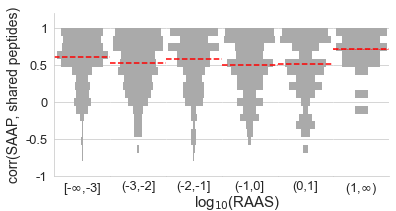

In [36]:
# plot violin plots of correlation distributions as function of RAAS for SAAP (middle panel)

fig,axes = plt.subplots(1, len(raas_bins), figsize=(6,3), sharey=True)
plt.subplots_adjust(wspace=0)
plt.ylim([-1,1.2])
sns.set_style('whitegrid')
for i,rbin in enumerate(raas_bins):
    ax = axes[i]
    #ax.set_ylim([-0.5,1])
    ax.set_xlabel(rbin, fontsize=13)
    ax.set_xticks([])
    rbin_data = all_corr_df.loc[all_corr_df['RAAS bin']==rbin, 'SAAP corr to mean SP'].values
    print(len(rbin_data))
    
    bihist(rbin_data, rbin_data, nbins=20, h=ax)
    if i>0:
        ax.spines['left'].set_visible(False)
       # ax.set_yticks([])
    ax.spines['top'].set_visible(False)

    median_corr = np.nanmedian(rbin_data)
    print(rbin, median_corr)
    ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r')
     
    if ax==axes[-1]:
        ax.spines['right'].set_visible(False)
        ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r', linewidth=0.5)
axes[0].set_ylabel('corr(SAAP, shared peptides)', fontsize=14)
axes[0].set_yticks([-1, -0.5,0,0.5,1])
axes[0].set_yticklabels([-1, -0.5,0,0.5,1], fontsize=13);

plt.annotate(r'log$_{10}$(RAAS)',(0.45,0.02), xycoords=('figure fraction'), fontsize=15)
plt.savefig(outdir+'SAAP_corr_to_median_SP.png', dpi=300, bbox_inches='tight')    

[-$\infty$,-3] 0.9321676436429178
(-3,-2] 0.885312951084278
(-2,-1] 0.8350935891543319
(-1,0] 0.7862042620195088
(0,1] 0.7738767343983077
(1,$\infty$) 0.7387370293696911


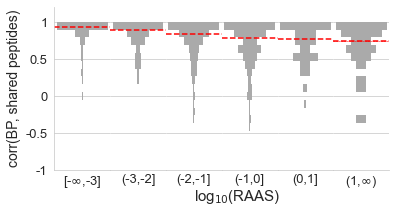

In [37]:
# plot violin plots of correlation distributions as function of RAAS for SAAP (top panel)

fig,axes = plt.subplots(1, len(raas_bins), figsize=(6,3), sharey=True)
plt.subplots_adjust(wspace=0)
plt.ylim([-1,1.2])
sns.set_style('whitegrid')
for i,rbin in enumerate(raas_bins):
    ax = axes[i]
    #ax.set_ylim([-0.5,1])
    ax.set_xlabel(rbin, fontsize=13)
    ax.set_xticks([])
    rbin_data = all_corr_df.loc[all_corr_df['RAAS bin']==rbin, 'BP corr to mean SP'].values
    
    bihist(rbin_data, rbin_data, nbins=20, h=ax)
    if i>0:
        ax.spines['left'].set_visible(False)
       # ax.set_yticks([])
    ax.spines['top'].set_visible(False)

    median_corr = np.nanmedian(rbin_data)
    print(rbin, median_corr)
    ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r')
     
    if ax==axes[-1]:
        ax.spines['right'].set_visible(False)
        ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r', linewidth=0.5)
axes[0].set_ylabel('corr(BP, shared peptides)', fontsize=14)
axes[0].set_yticks([-1, -0.5,0,0.5,1])
axes[0].set_yticklabels([-1, -0.5,0,0.5,1], fontsize=13);

plt.annotate(r'log$_{10}$(RAAS)',(0.45,0.02), xycoords=('figure fraction'), fontsize=15)
plt.savefig(outdir+'BP_corr_to_median_SP.png', dpi=300, bbox_inches='tight')    

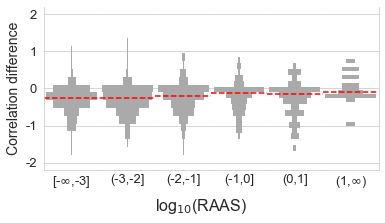

In [38]:
# plot violin plots of difference in correlation between SAAP and BP (lower panel)

fig,axes = plt.subplots(1, len(raas_bins), figsize=(6,3), sharey=True)
plt.subplots_adjust(wspace=0)
sns.set_style('whitegrid')
for i,rbin in enumerate(raas_bins):
    ax = axes[i]
    ax.set_xlabel(rbin, fontsize=13)
    ax.set_xticks([])
    rbin_data = [x for x in all_corr_df.loc[all_corr_df['RAAS bin']==rbin, 'SAAP - BP corr'].values if (~np.isnan(x) and (~np.isinf(x)))]
    
    bihist(rbin_data, rbin_data, nbins=20, h=ax)
    if i>0:
        ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

    median_corr = np.nanmedian(rbin_data)
    ax.plot(ax.get_xlim(), (median_corr, median_corr), '--r')

axes[0].set_ylabel('Correlation difference', fontsize=14)
axes[0].set_yticks([-2,-1,0,1,2])
axes[0].set_yticklabels([-2,-1,0,1,2], fontsize=13);


axes[2].annotate('log$_{10}$(RAAS)',(0,-0.25), xycoords=('axes fraction'), fontsize=16)

plt.savefig(outdir+'SAAP_minus_BP_corr_to_SP.png', dpi=300, bbox_inches='tight')    

### Figure 2i and extended data figure 3i: codon mismatch

In [39]:
codon2aa = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

AAs = 'ACDEFGHIKLMNPQRSTVWY'
subs_list = [i+' to '+j for i in AAs for j in AAs if i!=j]
subs_list = [x for x in subs_list if x[-1]!='L']
subs_list = [x if x[-1]!='I' else x[:-1]+'I/L' for x in subs_list]

# generate a dictionary with substitution types and their RAAS values for each dataset
aas_ratio_dict = {}
for i,ds in enumerate(datasets):
    print(ds)
    subs_dict = {x:[] for x in subs_list}
    mtp_quant = pickle.load(open(data_dir_list[i]+'MTP_quant_dict.p', 'rb'))
    for k,v in subs_dict.items():
        sub_peps = {i:x for i,x in mtp_quant.items() if x['aa_sub']==k}
        if len(sub_peps)>0:
            sub_ratios = [l for L in [[y for y in x['Prec_ratio'].values() if (~np.isnan(y)) and (~np.isinf(y))] for x in sub_peps.values()] for l in L]
            subs_dict[k] = v + sub_ratios
    aas_ratio_dict[ds] = subs_dict

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


In [40]:
# generate dataframe for plot

plot_rows = []
cols = ['Dataset', 'AAS', 'Minimum base error', 'Log substitution ratio', 'Bases changed']

for ds in datasets:
    subs_dict = aas_ratio_dict[ds]
    for k,v in subs_dict.items():
        base_codons = [i for i,x in codon2aa.items() if x==k[0]]
        dest_codons =  [i for i,x in codon2aa.items() if x==k[-1]]
        if base_codons!=dest_codons: # case of I/L to I/L
            min_change = 3
            min_changes = [1,2,3]
            for b in base_codons:
                for d in dest_codons:
                    change = len([x for i,x in enumerate(b) if d[i]!=x])
                    if change<min_change:
                        min_change=change
                        min_changes = [i+1 for i,x in enumerate(b) if d[i]!=x]
                    elif change==min_change:
                        new_changes = [i+1 for i,x in enumerate(b) if d[i]!=x]
                        if new_changes[0]>min_changes[0]:
                            min_changes=new_changes

            for aasr in v:
                aasr = np.log10(2**aasr)
                plot_rows.append([ds, k, min_change, aasr, min_changes])

plot_df = pd.DataFrame(plot_rows, columns=cols)
plot_df.to_excel(outdir+'Codon_change_df.xlsx')

In [ ]:
#plot_df = pd.read_excel(outdir+'Codon_change_df.xlsx', index_col=0)

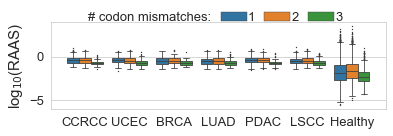

In [41]:
# plot for all dataset separately (extended 3i)

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(6,1.6))
sns.boxplot(data=plot_df, x='Dataset', y='Log substitution ratio', hue='Minimum base error', dodge=True, fliersize=0.5, linewidth=0.8)
plt.ylabel(r'log$_{10}$(RAAS)', fontsize=15);
plt.xlabel('')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
handles,labels = ax.get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
plt.legend(handles=ph+handles, labels=['# codon mismatches:']+labels ,bbox_to_anchor=(0.45,1.05), fontsize=13, ncol=4, frameon=False, 
           columnspacing=0.7, handletextpad=0.1, loc='center')
plt.savefig(outdir+'RAAS_vs_nCodonMismatches.pdf', bbox_inches='tight')

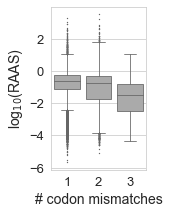

In [42]:
# plot for all dataset together (figure 2i)

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(1.7,3))
sns.boxplot(data=plot_df, x='Minimum base error', y='Log substitution ratio', fliersize=0.5, linewidth=0.8, color='#AAAAAA')
plt.ylabel(r'log$_{10}$(RAAS)', fontsize=14);
plt.xlabel('# codon mismatches', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(outdir+'allDS_RAAS_vs_nCodonMismatches.pdf', bbox_inches='tight')

### Extended data figure 3j. T and V tRNA ligase abundances 

In [43]:
 aa_name_letter_dict = {'cysteine': 'C', 'aspartate': 'D', 'serine': 'S', 'glutamine': 'Q', 'lysine': 'K',
     'isoleucine': 'I', 'proline': 'P', 'threonine': 'T', 'phenylalanine': 'F', 'asparagine': 'N', 
     'glycine': 'G', 'histidine': 'H', 'leucine': 'L', 'arginine': 'R', 'tryptophan': 'W', 
     'alanine': 'A', 'valine':'V', 'glutamate': 'E', 'tyrosine': 'Y', 'methionine': 'M'}

aa_letter_name_dict = {v:k for k,v in aa_name_letter_dict.items()}

# this dictionary was generated in a separate script using the MaxQuant protein output data
aars_abund_dict = pickle.load(open(dependencies_dir+'refnorm_AARS_abund_dict.p', 'rb'))

In [44]:
def get_boxplot_data(aas):
    """ function to get data for plotting tRNA ligase abundances of 2 amino acids, given a subsitution type"""
    aa1 = aa_letter_name_dict[aas[0]]
    aa2 = aa_letter_name_dict[aas[-1]]
    
    boxplot_rows = []
    cols=['Reporter-distributed\nprecursor intensity', 'tRNA ligase', 'Dataset']
    
    for ds in datasets[:-1]:
        aars_df = aars_abund_dict[ds]
        #aa1_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa1 in row['Unnamed: 0']) and ('mitochondria' not in row['Unnamed: 0'])],:].values[0][1:-1] if ~np.isnan(x)]
        #aa2_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa2 in row['Unnamed: 0']) and ('mitochondria' not in row['Unnamed: 0'])],:].values[0][1:-1] if ~np.isnan(x)]
        aa1_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa1 in i) and ('mitochondria' not in i)],:].values.flatten() if ~np.isnan(x)]
        aa2_aars_vals = [x for x in aars_df.loc[[i for i,row in aars_df.iterrows() if (aa2 in i) and ('mitochondria' not in i)],:].values.flatten() if ~np.isnan(x)]

        [boxplot_rows.append([val, aa1+'-tRNA ligase', ds]) for val in aa1_aars_vals]
        [boxplot_rows.append([val, aa2+'-tRNA ligase', ds]) for val in aa2_aars_vals]
    boxplot_df = pd.DataFrame(boxplot_rows, columns=cols)
    
    return(boxplot_df)

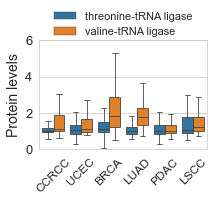

In [45]:
# generate boxplot for substitution type

aas = 'T to V'
boxplot_df = get_boxplot_data(aas)

fig,ax = plt.subplots(figsize=(3,2))
sns.boxplot(data=boxplot_df, y='Reporter-distributed\nprecursor intensity', x='Dataset', hue='tRNA ligase', linewidth=0.8, fliersize=0)
#plt.ylim([0,0.8])
ax.tick_params('y', labelsize=13)
plt.xlabel('')
plt.ylim([0,6])
ax.legend(bbox_to_anchor=(0.5,1.15), fontsize=11, title='', frameon=False, loc='center')
ax.tick_params('x', rotation=45, labelsize=12)
plt.ylabel('Protein levels', fontsize=14)
plt.savefig(outdir+'T2V_AAligase_abund.pdf', bbox_inches='tight')

### Figures 2k,l and Extended Data Figure 3l,m,n and Supplemental Figure 5: Protein turnover analysis with metabolic pulse SILAC data



In [52]:
savitski_dir = proj_dir+'pipeline_output/Savitski/'
aa_subs_dir = savitski_dir+'AA_subs_pipeline/'
val_dir = savitski_dir+'MSFragger_validation/'

cell_types = ['Hepatocytes','Bcells','Monocytes','NKcells']

# read in dataset metadata and create dictionary with values 
metadata = pd.read_csv(val_dir+'Meta.csv')
meta_dict = {}
for i,row in metadata.iterrows():
    meta_dict[row['raw file']] = {'celltype':row['cell type'], 'timepoint':row['time point'], 
                                      'replicate':row['replicate #'], 'time':row['time']}

In [53]:
# read in supplemental data file generated from output of running decode pipeline on the savitski data
# here there is one line per SAAP-BP per sample (replicates on separate lines)

quant_df = pd.read_excel(proj_dir+'Supplemental_Data_5.SAAP_SILAC_quant.xlsx', index_col=0) 

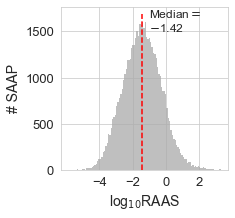

In [54]:
# plot of Hepatocyte RAAS, extended data figure 3l

fig,ax = plt.subplots(figsize=(3,3))
sns.histplot(data=quant_df, x='Light+Heavy RAAS', color='#AAAAAA', linewidth=0)
plt.xlabel('log$_{10}$RAAS', fontsize=14)
plt.ylabel('# SAAP', fontsize=14)
median = np.nanmedian(quant_df['Light+Heavy RAAS'])
plt.plot((median,median), ax.get_ylim(), '--r')
plt.annotate('Median$=$\n'+'$-$'+str(np.round(np.abs(median),2)), xy=(-1,1500), fontsize=12)
plt.xticks([-4,-2,0,2])
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'Savistki_allhepatocyte_RAAS_distribution.pdf', bbox_inches='tight')

In [ ]:
""" prepare dataframe for degradataion analysis """
### this file is also provided in the google drive folder pipeline_output/Savitski/AA_subs_pipeline/ 

# reformat the data in quant_df so that there is one line per SAAP-BP pair per cell type
# this is more convenient for computing degradation rates 


import warnings
warnings.filterwarnings("ignore")

rep_data_df_list = []
quant_data = quant_df

celltype = 'Hepatocytes'
for celltype in cell_types:
    print(celltype)
    cell_data = quant_data.loc[quant_data['Cell type']==celltype]
    saap_bp = list(set([row['SAAP']+';'+row['BP']+';'+row['AAS'] for i,row in cell_data.iterrows()]))
    print(len(saap_bp))
    timepoints = sorted(list(set(cell_data['Time'].to_list())))
    reps = list(set(cell_data['Replicate'].to_list()))

    cols = ['Cell type', 'SAAP', 'BP', 'AAS', 'CPTAC SAAP', 
            'BP_H_time1_rep1', 'BP_H_time1_rep2', 'BP_H_time2_rep1', 'BP_H_time2_rep2', 'BP_H_time3_rep1', 'BP_H_time3_rep2', 'BP_H_time4_rep1', 'BP_H_time4_rep2',
            'BP_L_time1_rep1', 'BP_L_time1_rep2', 'BP_L_time2_rep1', 'BP_L_time2_rep2', 'BP_L_time3_rep1', 'BP_L_time3_rep2', 'BP_L_time4_rep1', 'BP_L_time4_rep2',
            'BP_time1_rep1', 'BP_time1_rep2', 'BP_time2_rep1', 'BP_time2_rep2', 'BP_time3_rep1', 'BP_time3_rep2', 'BP_time4_rep1', 'BP_time4_rep2',
            'SAAP_H_time1_rep1', 'SAAP_H_time1_rep2', 'SAAP_H_time2_rep1', 'SAAP_H_time2_rep2', 'SAAP_H_time3_rep1', 'SAAP_H_time3_rep2', 'SAAP_H_time4_rep1', 'SAAP_H_time4_rep2',
            'SAAP_L_time1_rep1', 'SAAP_L_time1_rep2', 'SAAP_L_time2_rep1', 'SAAP_L_time2_rep2', 'SAAP_L_time3_rep1', 'SAAP_L_time3_rep2', 'SAAP_L_time4_rep1', 'SAAP_L_time4_rep2',
            'SAAP_time1_rep1', 'SAAP_time1_rep2', 'SAAP_time2_rep1', 'SAAP_time2_rep2', 'SAAP_time3_rep1', 'SAAP_time3_rep2', 'SAAP_time4_rep1', 'SAAP_time4_rep2', 
            'BP_HL_time1_rep1', 'BP_HL_time1_rep2', 'BP_HL_time2_rep1', 'BP_HL_time2_rep2', 'BP_HL_time3_rep1', 'BP_HL_time3_rep2', 'BP_HL_time4_rep1', 'BP_HL_time4_rep2',
            'SAAP_HL_time1_rep1', 'SAAP_HL_time1_rep2', 'SAAP_HL_time2_rep1', 'SAAP_HL_time2_rep2', 'SAAP_HL_time3_rep1', 'SAAP_HL_time3_rep2', 'SAAP_HL_time4_rep1', 'SAAP_HL_time4_rep2', 
            'RAAS_time1_rep1', 'RAAS_time1_rep2', 'RAAS_time2_rep1', 'RAAS_time2_rep2', 'RAAS_time3_rep1', 'RAAS_time3_rep2', 'RAAS_time4_rep1', 'RAAS_time4_rep2',
            'BP_H_mean_time1', 'BP_H_mean_time2', 'BP_H_mean_time3', 'BP_H_mean_time4',
            'BP_L_mean_time1', 'BP_L_mean_time2', 'BP_L_mean_time3', 'BP_L_mean_time4',
            'BP_mean_time1', 'BP_mean_time2', 'BP_mean_time3', 'BP_mean_time4', 
            'SAAP_H_mean_time1', 'SAAP_H_mean_time2', 'SAAP_H_mean_time3', 'SAAP_H_mean_time4',
            'SAAP_L_mean_time1', 'SAAP_L_mean_time2', 'SAAP_L_mean_time3', 'SAAP_L_mean_time4',
            'SAAP_mean_time1', 'SAAP_mean_time2', 'SAAP_mean_time3','SAAP_mean_time4', 
            'BP_HL_mean_time1', 'BP_HL_mean_time2', 'BP_HL_mean_time3', 'BP_HL_mean_time4', 
            'SAAP_HL_mean_time1', 'SAAP_HL_mean_time2', 'SAAP_HL_mean_time3', 'SAAP_HL_mean_time4',
            'RAAS_mean_time1', 'RAAS_mean_time2', 'RAAS_mean_time3', 'RAAS_mean_time4', 'N_timepoints',
            'BP_H_mean', 'BP_H_std','BP_H_CV', 'BP_L_mean', 'BP_L_std','BP_L_CV', 'BP_mean', 'BP_std','BP_CV',
            'SAAP_H_mean', 'SAAP_H_std','SAAP_H_CV', 'SAAP_L_mean', 'SAAP_L_std','SAAP_L_CV','SAAP_mean','SAAP_std','SAAP_CV',
            'BP_HL_mean','BP_HL_std','BP_HL_CV','SAAP_HL_mean','SAAP_HL_std','SAAP_HL_CV','RAAS_mean','RAAS_std','RAAS_CV']
    rep_data_df = pd.DataFrame(index=list(range(len(saap_bp))), columns=cols)

    for i, sba in enumerate(saap_bp):
        if i%1000==0:
            print(i)
        sba_split = sba.split(';')
        saap = sba_split[0]
        bp = sba_split[1]
        aas = sba_split[2]

        rep_data_df.loc[i, 'Cell type'] = celltype
        rep_data_df.loc[i, 'SAAP'] = saap
        rep_data_df.loc[i, 'BP'] = bp
        rep_data_df.loc[i, 'AAS'] = aas

        sba_df = cell_data.loc[(cell_data['SAAP']==saap) & (cell_data['BP']==bp)]
        cptac = sba_df['CPTAC SAAP'].values[0]
        rep_data_df.loc[i,'CPTAC SAAP'] = cptac
        #sba_df

        for j,tp in enumerate(timepoints):
            rep1_df = sba_df.loc[(sba_df['Time']==tp) & (sba_df['Replicate']==1)]
            rep2_df = sba_df.loc[(sba_df['Time']==tp) & (sba_df['Replicate']==2)]

            bp_h_1 = rep1_df['Heavy BP intensity'].values[0]
            bp_h_2 = rep2_df['Heavy BP intensity'].values[0]
            bp_l_1 = rep1_df['Light BP intensity'].values[0]
            bp_l_2 = rep2_df['Light BP intensity'].values[0]
            bp_1 = rep1_df['Light+Heavy BP intensity'].values[0]
            bp_2 = rep2_df['Light+Heavy BP intensity'].values[0]
            bp_hl_1 = rep1_df['H/L BP intensity'].values[0]
            bp_hl_2 = rep2_df['H/L BP intensity'].values[0]
            saap_h_1 = rep1_df['Heavy SAAP intensity'].values[0]
            saap_h_2 = rep2_df['Heavy SAAP intensity'].values[0]
            saap_l_1 = rep1_df['Light SAAP intensity'].values[0]
            saap_l_2 = rep2_df['Light SAAP intensity'].values[0]
            saap_1 = rep1_df['Light+Heavy SAAP intensity'].values[0]
            saap_2 = rep2_df['Light+Heavy SAAP intensity'].values[0]
            saap_hl_1 = rep1_df['H/L SAAP intensity'].values[0]
            saap_hl_2 = rep2_df['H/L SAAP intensity'].values[0]
            raas_1 = rep1_df['Light+Heavy RAAS'].values[0]
            raas_2 = rep2_df['Light+Heavy RAAS'].values[0]

            rep_data_df.loc[i, 'BP_H_time'+str(j+1)+'_rep1'] = bp_h_1
            rep_data_df.loc[i, 'BP_H_time'+str(j+1)+'_rep2'] = bp_h_2
            rep_data_df.loc[i, 'BP_L_time'+str(j+1)+'_rep1'] = bp_l_1
            rep_data_df.loc[i, 'BP_L_time'+str(j+1)+'_rep2'] = bp_l_2
            rep_data_df.loc[i, 'BP_time'+str(j+1)+'_rep1'] = bp_1
            rep_data_df.loc[i, 'BP_time'+str(j+1)+'_rep2'] = bp_2
            rep_data_df.loc[i, 'SAAP_H_time'+str(j+1)+'_rep1'] = saap_h_1
            rep_data_df.loc[i, 'SAAP_H_time'+str(j+1)+'_rep2'] = saap_h_2
            rep_data_df.loc[i, 'SAAP_L_time'+str(j+1)+'_rep1'] = saap_l_1
            rep_data_df.loc[i, 'SAAP_L_time'+str(j+1)+'_rep2'] = saap_l_2
            rep_data_df.loc[i, 'SAAP_time'+str(j+1)+'_rep1'] = saap_1
            rep_data_df.loc[i, 'SAAP_time'+str(j+1)+'_rep2'] = saap_2
            rep_data_df.loc[i, 'BP_HL_time'+str(j+1)+'_rep1'] = bp_hl_1
            rep_data_df.loc[i, 'BP_HL_time'+str(j+1)+'_rep2'] = bp_hl_2
            rep_data_df.loc[i, 'SAAP_HL_time'+str(j+1)+'_rep1'] = saap_hl_1
            rep_data_df.loc[i, 'SAAP_HL_time'+str(j+1)+'_rep2'] = saap_hl_2
            rep_data_df.loc[i, 'RAAS_time'+str(j+1)+'_rep1'] = raas_1
            rep_data_df.loc[i, 'RAAS_time'+str(j+1)+'_rep2'] = raas_2

            rep_data_df.loc[i, 'BP_H_mean_time'+str(j+1)] = np.nanmean([bp_h_1,bp_h_2])
            rep_data_df.loc[i, 'BP_L_mean_time'+str(j+1)] = np.nanmean([bp_l_1,bp_l_2])
            rep_data_df.loc[i, 'BP_mean_time'+str(j+1)] = np.nanmean([bp_1,bp_2])
            rep_data_df.loc[i, 'SAAP_H_mean_time'+str(j+1)] = np.nanmean([saap_h_1,saap_h_2])
            rep_data_df.loc[i, 'SAAP_L_mean_time'+str(j+1)] = np.nanmean([saap_l_1,saap_l_2])
            rep_data_df.loc[i, 'SAAP_mean_time'+str(j+1)] = np.nanmean([saap_1,saap_2])
            rep_data_df.loc[i, 'BP_HL_mean_time'+str(j+1)] = np.nanmean([bp_hl_1,bp_hl_2])
            rep_data_df.loc[i, 'SAAP_HL_mean_time'+str(j+1)] = np.nanmean([saap_hl_1,saap_hl_2])
            rep_data_df.loc[i, 'RAAS_mean_time'+str(j+1)] = np.nanmean([raas_1,raas_2])

        rep_data_df.loc[i, 'N_timepoints'] = len([x for x in rep_data_df.loc[i,[c for c in rep_data_df.columns if 'RAAS_mean_time' in c]] if ~np.isnan(x)])

        bp_h_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_H_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_H_mean'] = np.nanmean(bp_h_vals)
        rep_data_df.loc[i, 'BP_H_std'] = np.nanstd(bp_h_vals)
        rep_data_df.loc[i, 'BP_H_CV'] = np.nanstd(bp_h_vals)/np.nanmean(bp_h_vals)
        bp_l_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_L_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_L_mean'] = np.nanmean(bp_l_vals)
        rep_data_df.loc[i, 'BP_L_std'] = np.nanstd(bp_l_vals)
        rep_data_df.loc[i, 'BP_L_CV'] = np.nanstd(bp_l_vals)/np.nanmean(bp_l_vals)
        bp_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_mean'] = np.nanmean(bp_vals)
        rep_data_df.loc[i, 'BP_std'] = np.nanstd(bp_vals)
        rep_data_df.loc[i, 'BP_CV'] = np.nanstd(bp_vals)/np.nanmean(bp_vals)
        saap_h_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_H_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_H_mean'] = np.nanmean(saap_h_vals)
        rep_data_df.loc[i, 'SAAP_H_std'] = np.nanstd(saap_h_vals)
        rep_data_df.loc[i, 'SAAP_H_CV'] = np.nanstd(saap_h_vals)/np.nanmean(saap_h_vals)
        saap_l_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_L_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_L_mean'] = np.nanmean(saap_l_vals)
        rep_data_df.loc[i, 'SAAP_L_std'] = np.nanstd(saap_l_vals)
        rep_data_df.loc[i, 'SAAP_L_CV'] = np.nanstd(saap_l_vals)/np.nanmean(saap_l_vals)
        saap_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_mean'] = np.nanmean(saap_vals)
        rep_data_df.loc[i, 'SAAP_std'] = np.nanstd(saap_vals)
        rep_data_df.loc[i, 'SAAP_CV'] = np.nanstd(saap_vals)/np.nanmean(saap_vals)
        bp_hl_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'BP_HL_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'BP_HL_mean'] = np.nanmean(bp_hl_vals)
        rep_data_df.loc[i, 'BP_HL_std'] = np.nanstd(bp_hl_vals)
        rep_data_df.loc[i, 'BP_HL_CV'] = np.nanstd(bp_hl_vals)/np.nanmean(bp_hl_vals)
        saap_hl_vals = rep_data_df.loc[i,[x for x in rep_data_df.columns if 'SAAP_HL_mean_time' in x]].to_list()
        rep_data_df.loc[i, 'SAAP_HL_mean'] = np.nanmean(saap_hl_vals)
        rep_data_df.loc[i, 'SAAP_HL_std'] = np.nanstd(saap_hl_vals)
        rep_data_df.loc[i, 'SAAP_HL_CV'] = np.nanstd(saap_hl_vals)/np.nanmean(saap_hl_vals)
        raas_vals = [10**x for x in rep_data_df.loc[i,[x for x in rep_data_df.columns if 'RAAS_mean_time' in x]].to_list()]
        rep_data_df.loc[i, 'RAAS_mean'] = np.log10(np.nanmean(raas_vals))
        rep_data_df.loc[i, 'RAAS_std'] = np.nanstd(raas_vals)
        rep_data_df.loc[i, 'RAAS_CV'] = np.nanstd(raas_vals)/np.nanmean(raas_vals)

    rep_data_df_list.append(rep_data_df)

In [ ]:
# add columns with log of the abundance values for all heavy and light peptides and save file

new_rep_data_df_list = []
for i,rep_data_df in enumerate(rep_data_df_list):
    celltype = rep_data_df['Cell type'].values[0]
    print(celltype)
    cell_meta = metadata.loc[metadata['cell type']==celltype]
    timepoints = list(set(cell_meta['time point'].to_list()))
    timepoints = [str(y)+'h' for y in sorted([int(x.split('h')[0]) for x in timepoints])]
    for j,tp in enumerate(timepoints): 
        print(tp)
        rep_data_df['BP_H_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_H_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_H_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_H_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_L_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_L_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_L_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_L_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_H_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_H_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_H_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_H_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_L_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_L_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_L_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_L_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_H_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_H_time'+str(j+1)+'_rep1'], row['BP_H_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['BP_L_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_L_time'+str(j+1)+'_rep1'], row['BP_L_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['BP_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_time'+str(j+1)+'_rep1'], row['BP_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_H_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_H_time'+str(j+1)+'_rep1'], row['SAAP_H_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_L_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_L_time'+str(j+1)+'_rep1'], row['SAAP_L_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_time'+str(j+1)+'_rep1'], row['SAAP_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]

        rep_data_df['BP_HL_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_HL_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1_log'] = [np.log10(x) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2_log'] = [np.log10(x) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['BP_HL_time'+str(j+1)+'_rep1_log+1'] = [np.log10(x+1) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['BP_HL_time'+str(j+1)+'_rep2_log+1'] = [np.log10(x+1) for x in rep_data_df['BP_HL_time'+str(j+1)+'_rep2'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1_log+1'] = [np.log10(x+1) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep1'].to_list()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2_log+1'] = [np.log10(x+1) for x in rep_data_df['SAAP_HL_time'+str(j+1)+'_rep2'].to_list()]

        rep_data_df['BP_HL_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['BP_HL_time'+str(j+1)+'_rep1'], row['BP_HL_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_mean_log'] = [np.log10(np.nanmean([row['SAAP_HL_time'+str(j+1)+'_rep1'], row['SAAP_HL_time'+str(j+1)+'_rep2']])) for i,row in rep_data_df.iterrows()]
        rep_data_df['BP_HL_time'+str(j+1)+'_mean_log+1'] = [np.log10(np.nanmean([row['BP_HL_time'+str(j+1)+'_rep1'], row['BP_HL_time'+str(j+1)+'_rep2']])+1) for i,row in rep_data_df.iterrows()]
        rep_data_df['SAAP_HL_time'+str(j+1)+'_mean_log+1'] = [np.log10(np.nanmean([row['SAAP_HL_time'+str(j+1)+'_rep1'], row['SAAP_HL_time'+str(j+1)+'_rep2']])+1) for i,row in rep_data_df.iterrows()]
    new_rep_data_df_list.append(rep_data_df)
    
rep_data_df_all = pd.concat(rep_data_df_list)
rep_data_df.replace(np.inf, np.nan, inplace=True)
rep_data_df.replace(-np.inf, np.nan, inplace=True)
rep_data_df_all.to_csv(aa_subs_dir+'Median_normalized_Replicate_data_all_celltypes.csv')

In [60]:
# compute degradation rates 

def get_model_params(x,y):
    """ 
    Generate linear regression model to fit peptide abundance data to time points
    input: x - timepoints; y - abundance data (or H/L to compute degradation rates)
    output: slope of regression (this is the degradation rate when fitting H/L), R^2 of the fit, and predicted y values
    """
    x = np.array(x).reshape(-1,1)
    y = np.array(y)
    model = LinearRegression(fit_intercept=False)
    model.fit(x, y)
    y_pred = model.predict(x)
    slope = model.coef_[0]
    score = model.score(x,y)
    return(slope, score, y_pred)

In [ ]:
# compute degradation rates of heavy and light and H/L ratio 

bp_deg_rates = []
saap_deg_rates = []
bp_deg_r2_list = []
saap_deg_r2_list = []
bp_deg_pred_list = []
saap_deg_pred_list = []
n_bp_times_in_deg = []
n_saap_times_in_deg = []

bp_light_slope_list = []
saap_light_slope_list = []
bp_light_r2_list = []
saap_light_r2_list = []
bp_light_pred_list = []
saap_light_pred_list = []

bp_heavy_slope_list = []
saap_heavy_slope_list = []
bp_heavy_r2_list = []
saap_heavy_r2_list = []
bp_heavy_pred_list = []
saap_heavy_pred_list = []

i=0
row = rep_data_df_all.loc[i]

for i,row in rep_data_df_all.iterrows():
    if i%1000==0:
        print(i)
    celltype = row['Cell type']
    x = ordered_times[celltype]

    bp_hl = [row['BP_HL_time'+str(j)+'_mean_log+1'] for j in range(1,5)]
    x_bp_hl = [x[j] for j in range(len(x)) if ~np.isnan(bp_hl[j])]
    bp_hl = [x for x in bp_hl if ~np.isnan(x)]
    n_bp = len(bp_hl)

    saap_hl = [row['SAAP_HL_time'+str(j)+'_mean_log+1'] for j in range(1,5)]
    x_saap_hl = [x[j] for j in range(len(x)) if ~np.isnan(saap_hl[j])]
    saap_hl = [x for x in saap_hl if ~np.isnan(x)]
    n_saap = len(saap_hl)

    bp_deg_slope = saap_deg_slope = np.nan
    bp_deg_r2 = saap_deg_r2 = np.nan
    bp_deg_pred = saap_deg_pred = np.nan
    if len(bp_hl)>0:
        bp_deg_slope, bp_deg_r2, bp_deg_pred = get_model_params(x_bp_hl, bp_hl)
    if len(saap_hl)>0:
        saap_deg_slope, saap_deg_r2, saap_deg_pred = get_model_params(x_saap_hl, saap_hl)

    bp_deg_rates.append(bp_deg_slope)
    saap_deg_rates.append(saap_deg_slope)
    bp_deg_r2_list.append(bp_deg_r2)
    saap_deg_r2_list.append(saap_deg_r2)
    bp_deg_pred_list.append(bp_deg_pred)
    saap_deg_pred_list.append(saap_deg_pred)
    n_bp_times_in_deg.append(n_bp)
    n_saap_times_in_deg.append(n_saap)


    bp_light = [row['BP_L_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_bp_light = [x[j] for j in range(len(x)) if ~np.isnan(bp_light[j])]
    bp_light = [x for x in bp_light if ~np.isnan(x)]

    saap_light = [row['SAAP_L_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_saap_light = [x[j] for j in range(len(x)) if ~np.isnan(saap_light[j])]
    saap_light = [x for x in saap_light if ~np.isnan(x)]

    bp_light_slope = saap_light_slope = np.nan
    bp_light_r2 = saap_light_r2 = np.nan
    bp_light_pred = saap_light_pred = np.nan
    if len(bp_light)>0:
        bp_light_slope, bp_light_r2, bp_light_pred = get_model_params(x_bp_light, bp_light)
    if len(saap_light)>0:
        saap_light_slope, saap_light_r2, saap_light_pred = get_model_params(x_saap_light, saap_light)

    bp_light_slope_list.append(bp_light_slope)
    saap_light_slope_list.append(saap_light_slope)
    bp_light_r2_list.append(bp_light_r2)
    saap_light_r2_list.append(saap_light_r2)
    bp_light_pred_list.append(bp_light_pred)
    saap_light_pred_list.append(saap_light_pred)


    bp_heavy = [row['BP_H_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_bp_heavy = [x[j] for j in range(len(x)) if ~np.isnan(bp_heavy[j])]
    bp_heavy = [x for x in bp_heavy if ~np.isnan(x)]

    saap_heavy = [row['SAAP_H_time'+str(j)+'_mean_log'] for j in range(1,5)]
    x_saap_heavy = [x[j] for j in range(len(x)) if ~np.isnan(saap_heavy[j])]
    saap_heavy = [x for x in saap_heavy if ~np.isnan(x)]

    bp_heavy_slope = saap_heavy_slope = np.nan
    bp_heavy_r2 = saap_heavy_r2 = np.nan
    bp_heavy_pred = saap_heavy_pred = np.nan
    if len(bp_heavy)>0:
        bp_heavy_slope, bp_heavy_r2, bp_heavy_pred = get_model_params(x_bp_heavy, bp_heavy)
    if len(saap_heavy)>0:
        saap_heavy_slope, saap_heavy_r2, saap_heavy_pred = get_model_params(x_saap_heavy, saap_heavy)

    bp_heavy_slope_list.append(bp_heavy_slope)
    saap_heavy_slope_list.append(saap_heavy_slope)    
    bp_heavy_r2_list.append(bp_heavy_r2)
    saap_heavy_r2_list.append(saap_heavy_r2)
    bp_heavy_pred_list.append(bp_heavy_pred)
    saap_heavy_pred_list.append(saap_heavy_pred)
    
rep_data_df_all['BP_deg_rate'] = bp_deg_rates
rep_data_df_all['SAAP_deg_rate'] = saap_deg_rates
rep_data_df_all['BP_deg_rate_log'] = [np.log10(x) for x in rep_data_df_all['BP_deg_rate'].to_list()]
rep_data_df_all['SAAP_deg_rate_log'] = [np.log10(x) for x in rep_data_df_all['SAAP_deg_rate'].to_list()]
rep_data_df_all['BP_N_timepoints_in_deg'] = n_bp_times_in_deg
rep_data_df_all['SAAP_N_timepoints_in_deg'] = n_saap_times_in_deg

rep_data_df_all['BP_deg_r2'] = bp_deg_r2_list
rep_data_df_all['SAAP_deg_r2'] = saap_deg_r2_list
rep_data_df_all['BP_deg_predicted'] = bp_deg_pred_list
rep_data_df_all['SAAP_deg_predicted'] = saap_deg_pred_list

rep_data_df_all['BP_light_slope'] = bp_light_slope_list
rep_data_df_all['SAAP_light_slope'] = saap_light_slope_list
rep_data_df_all['BP_light_r2'] = bp_light_r2_list
rep_data_df_all['SAAP_light_r2'] = saap_light_r2_list
rep_data_df_all['BP_light_predicted'] = bp_light_pred_list
rep_data_df_all['SAAP_light_predicted'] = saap_light_pred_list

rep_data_df_all['BP_heavy_slope'] = bp_heavy_slope_list
rep_data_df_all['SAAP_heavy_slope'] = saap_heavy_slope_list
rep_data_df_all['BP_heavy_r2'] = bp_heavy_r2_list
rep_data_df_all['SAAP_heavy_r2'] = saap_heavy_r2_list
rep_data_df_all['BP_heavy_predicted'] = bp_heavy_pred_list
rep_data_df_all['SAAP_heavy_predicted'] = saap_heavy_pred_list

# compute ratio of SAAP degradation rate to BP degradation rate 
rep_data_df_all['SAAP_BP_deg_rate'] = [row['SAAP_deg_rate']/row['BP_deg_rate'] for i,row in rep_data_df_all.iterrows()]
rep_data_df_all['SAAP_BP_deg_rate_log'] = [np.log2(x) for x in rep_data_df_all['SAAP_BP_deg_rate'].to_list()]

rep_data_df_all.to_csv(outdir+'Median_normalized_Replicate_data_all_celltypes.csv')

Read in data file here if did not reproduce

In [58]:
rep_data_df_all = pd.read_csv(aa_subs_dir+'Median_normalized_Replicate_data_all_celltypes.csv', index_col=0)

-0.156694532009009 3.5892058398423516e-20
-0.15420199420607894 1.6661524248257123e-15
-0.16804777928146492 2.7874626007784604e-06


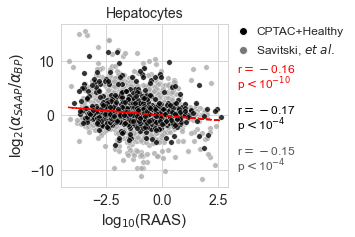

In [64]:
# plot ratio of SAAP degradation to BP degradation vs RAAS for given cell type. Figure 2l, extended data figure 3 m,n.

celltype = 'Hepatocytes' # change for other cell types 

rep_data_df = rep_data_df_all.loc[rep_data_df_all['Cell type']==celltype]
#rep_data_df = rep_data_df.loc[(rep_data_df['BP_N_timepoints_in_deg']>2) & (rep_data_df['SAAP_N_timepoints_in_deg']>2)]
rep_data_df.dropna(inplace=True, subset=['SAAP_BP_deg_rate_log', 'RAAS_mean'])


sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))

subset1_df = rep_data_df.loc[rep_data_df['CPTAC SAAP']==False]
subset2_df = rep_data_df.loc[rep_data_df['CPTAC SAAP']==True]

sns.scatterplot(data=rep_data_df, x='RAAS_mean', y='SAAP_BP_deg_rate_log', s=30, alpha=0, hue='CPTAC SAAP', palette=['#AAAAAA', 'k'])#, palette='RdBu_r')
sns.scatterplot(data=subset1_df, x='RAAS_mean', y='SAAP_BP_deg_rate_log', s=30, alpha=0.8, color='#AAAAAA')#, palette='RdBu_r')
sns.scatterplot(data=subset2_df, x='RAAS_mean', y='SAAP_BP_deg_rate_log', s=30, alpha=0.8, color='k')#, palette='RdBu_r')

#scatter = plt.scatter(data=hep_data, x='Light+Heavy RAAS', y='RTO', s=30, alpha=0.5, edgecolor='w', linewidth=0.7)
vect2 = [float(x) for x in rep_data_df['SAAP_BP_deg_rate_log'].values]
vect1 = [float(x) for x in rep_data_df['RAAS_mean'].values]
y_vals = get_model_params(vect1,vect2)[2]
plt.plot(vect1, y_vals, '--r')

vect1_2 = subset1_df['SAAP_BP_deg_rate_log'].values
vect1_1 = subset1_df['RAAS_mean'].values
y1_vals = get_model_params(vect1_1, vect1_2)[2]
#plt.plot(vect1_1, y1_vals, '--', color='#555555')

vect2_2 = subset2_df['SAAP_BP_deg_rate_log'].values
vect2_1 = subset2_df['RAAS_mean'].values
y2_vals = get_model_params(vect2_1,vect2_2)[2]
#plt.plot(vect2_1, y2_vals, '--', color='k')

r,p = sp.stats.pearsonr(vect1, vect2)
r1,p1 = sp.stats.pearsonr(vect1_1, vect1_2)
r2,p2 = sp.stats.pearsonr(vect2_1, vect2_2)
print(r,p)
print(r1,p1)
print(r2,p2)

ax.annotate('r$=-$'+str(np.round(np.abs(r),2)), xy=(1.05,0.7), xycoords='axes fraction', fontsize=12, color='r')
ax.annotate('p$<$10$^{-10}$', xy=(1.05,0.6), xycoords='axes fraction', fontsize=12,color='r')
#ax.annotate('p$=$0.95', xy=(1.05,0.6), xycoords='axes fraction', fontsize=12, color='r')

ax.annotate('r$=-$'+str(np.round(np.abs(r2),2)), xy=(1.05,0.45), xycoords='axes fraction', fontsize=12, color='k')
ax.annotate('p$<$10$^{-4}$', xy=(1.05,0.35), xycoords='axes fraction', fontsize=12, color='k')
#ax.annotate('p$=$0.06', xy=(1.05,0.35), xycoords='axes fraction', fontsize=12, color='k')

ax.annotate('r$=-$'+str(np.round(np.abs(r1),2)), xy=(1.05,0.2), xycoords='axes fraction', fontsize=12, color='#555555')
ax.annotate('p$<$10$^{-4}$', xy=(1.05,0.1), xycoords='axes fraction', fontsize=12, color='#555555')
#ax.annotate('p$=$0.73', xy=(1.05,0.1), xycoords='axes fraction', fontsize=12, color='#555555')

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8), Line2D([0], [0], marker='o', color='w', markerfacecolor='#555555', markersize=8, alpha=0.8)]
plt.legend(fontsize=12,handles=handles, labels=['CPTAC+Healthy', 'Savitski, $\it{et\ al.}$'], handletextpad=0.1,
          bbox_to_anchor=(1.75,1.05), frameon=False, loc='upper right')

ax.tick_params('both', labelsize=14)
plt.ylabel('log$_{2}$('+r'$\alpha_{SAAP}$'+'$/$'+r'$\alpha_{BP}$'+')', fontsize=15)
plt.xlabel('log$_{10}$(RAAS)', fontsize=15)

plt.title(celltype, fontsize=14)
#plt.title('B Cells', fontsize=14)

plt.savefig(outdir+celltype+'_log2_SAAP_BP_deg_vs_RAAS.png', dpi=300, bbox_inches='tight')

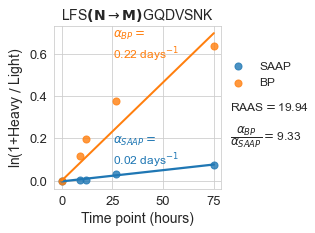

In [77]:
# plot example of H/L ratios relative to time point to illustrate computation. Figure 2k


# filter rep_data_df_all for peptides with no missing data, high R2, high RAAS and low SAAP degradation to find example
rep_data_df = rep_data_df_all.loc[rep_data_df_all['Cell type']=='Hepatocytes']
rep_data_df = rep_data_df.loc[(rep_data_df['SAAP_N_timepoints_in_deg']==4) & (rep_data_df['BP_N_timepoints_in_deg']==4)]
rep_data_df = rep_data_df.loc[(rep_data_df['SAAP_deg_r2']>=0.5) & (rep_data_df['BP_deg_r2']>=0.5)]
example_df = rep_data_df.loc[(rep_data_df['SAAP_BP_deg_rate_log']<0) & (rep_data_df['RAAS_mean']>1)]
cell_quant_data = quant_df.loc[quant_df['Cell type']=='Hepatocytes']

example_row = example_df.loc[[i for i,row in example_df.iterrows() if row['SAAP']=='LFSNGQDVSNK']]

# extract data for plot. convert log10 to ln. 
saap = example_row['SAAP'].values[0]
bp = example_row['BP'].values[0]
aas = example_row['AAS'].values[0]
raas = example_row['RAAS_mean'].values[0]
saap_deg = np.log(10**(example_row['SAAP_deg_rate'].values[0]))
bp_deg = np.log(10**(example_row['BP_deg_rate'].values[0]))
saap_bp_deg = saap_deg/bp_deg

saap_deg_day = 24*saap_deg
bp_deg_day = 24*bp_deg

#if read in rep_data_df
saap_hl_pred = [np.log(10**float(x)) for x in example_row['SAAP_deg_predicted'].values[0][1:-1].split(' ') if len(x)>0]
bp_hl_pred = [np.log(10**float(x)) for x in example_row['BP_deg_predicted'].values[0][1:-1].split(' ') if len(x)>0]

# if generated new rep_data_df
#saap_hl_pred = [np.log(10**x) for x in example_row['SAAP_deg_predicted'].values[0]]
#bp_hl_pred = [np.log(10**x) for x in example_row['BP_deg_predicted'].values[0]]

row_quant = cell_quant_data.loc[(cell_quant_data['SAAP']==saap) & (cell_quant_data['BP']==bp)]
tps = sorted(list(set(row_quant['Time'])))
saap_light_tps = []
saap_heavy_tps = []
bp_light_tps = []
bp_heavy_tps = []
saap_hl_tps = []
bp_hl_tps = []

for tp in tps:
    tp_quant = row_quant.loc[row_quant['Time']==tp]
    rep1_row = tp_quant.loc[tp_quant['Replicate']==1]
    rep2_row = tp_quant.loc[tp_quant['Replicate']==2]
    time = rep1_row['Time'].values[0]
    hl_saap = np.nanmean([np.log(rep1_row['H/L SAAP intensity'].values[0]+1), np.log(rep2_row['H/L SAAP intensity'].values[0]+1)])
    hl_bp = np.nanmean([np.log(rep1_row['H/L BP intensity'].values[0]+1), np.log(rep2_row['H/L BP intensity'].values[0]+1)])
    saap_hl_tps.append(hl_saap)
    bp_hl_tps.append(hl_bp)

    
# plot figure 2k
fig,ax = plt.subplots(figsize=(3,3))
tps = [0]+tps
saap_hl_tps = [0] + saap_hl_tps
bp_hl_tps = [0] + bp_hl_tps
bp_hl_pred = [0] + bp_hl_pred

sns.regplot(x=tps, y=saap_hl_tps, label='SAAP_H/L', ci=None, scatter_kws={'s':50})
sns.regplot(x=tps, y=bp_hl_tps, label='BP_H/L', ci=None, scatter_kws={'s':50}, line_kws={'linewidth':0})
sns.lineplot(x=tps, y=bp_hl_pred, color=colors[1], linewidth=2)
aas_idx = [i for i,x in enumerate(saap) if bp[i]!=x][0]
plt.title(saap[:aas_idx]+r'$\bf(N$'+r'$\rightarrow$'+r'$\bf M)$'+saap[aas_idx+1:], fontsize=14)
ax.tick_params('both', labelsize=13)
plt.ylabel('ln(1+Heavy $/$ Light)', fontsize=14)
plt.xlabel('Time point (hours)', fontsize=14)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels =['SAAP', 'BP'], bbox_to_anchor=(0.96,0.85), frameon=False, loc='upper left', fontsize=12)
plt.annotate('RAAS$=$'+str(np.round(10**raas,2)), xy=(1.05,0.48), xycoords='axes fraction', fontsize=12)
plt.annotate(r'$\dfrac{\alpha_{BP}}{\alpha_{SAAP}}$'+'$=$'+str(np.round(np.abs(1/saap_bp_deg),2)), xy=(1.05,0.3), xycoords='axes fraction', fontsize=12)
plt.annotate(r'$\alpha_{SAAP}=$'+'\n'+str(np.round(saap_deg_day,2))+' days$^{-1}$',xy=(0.35,0.15), xycoords='axes fraction', color=colors[0], fontsize=12)
plt.annotate(r'$\alpha_{BP}=$'+'\n'+str(np.round(bp_deg_day,2))+' days$^{-1}$',xy=(0.35,0.8), xycoords='axes fraction', color=colors[1], fontsize=12)
plt.savefig(outdir+'saap_bp_hl_example4fig2.pdf', bbox_inches='tight')


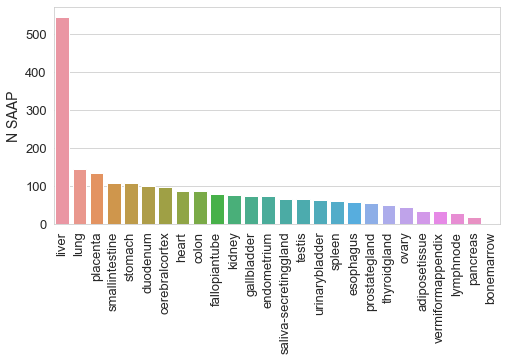

In [91]:
# see which tissues SAAP identified in this dataset were identified in in the healthy human tissue data 
# Supp. Figure 5a

celltype = 'Hepatocytes'
pep_df = pd.read_csv(val_dir+celltype+'/Results/combined_modified_peptide_label_quant.tsv', sep='\t')

fasta = open(savitski_dir+'databases/2024-07-21-decoys-contam-human_MTP_Hepatocytes.fasta.fas', 'r').read()
fasta_entries = [x for x in fasta.split('>')]
allpeps = list(set(pep_df['Peptide Sequence'].to_list()))
all_mtps = [x for x in fasta_entries if re.match('MTP\|', x)] # these come from Savitski DP search 
all_saap = [x for x in fasta_entries if re.match('SAAP_', x)] # these come from CPTAC/label-free DP searches

all_mtp_ids = [x.split('\n')[0] for x in all_mtps]
all_mtp_seqs = [x.split('\n')[1] for x in all_mtps]
all_saap = [x for x in all_saap if len(x.split('\n'))>1]
all_saap_ids = [x.split('\n')[0] for x in all_saap]
all_saap_seqs = [x.split('\n')[1] for x in all_saap]

# get all peptide sequences that were validated by MSFragger search 
mtp_saap_peps = [x for x in allpeps if x in all_mtp_seqs and x in all_saap_seqs]
mtp_peps = [x for x in allpeps if x in all_mtp_seqs and x not in all_saap_seqs]
saap_peps = [x for x in allpeps if x not in all_mtp_seqs and x in all_saap_seqs]
other_peps = [x for x in allpeps if x not in all_mtp_seqs and x not in all_saap_seqs]

val_saap = mtp_saap_peps + saap_peps 
set_tissues = list(set(filt_prec_quant_df['TMT/Tissue'].to_list()))
set_tissues = [x for x in set_tissues if not re.match('S[1-9]', x)]

# generate dataframe with the number of validated SAAP that were found in each type of healthy tissue
plot_rows = []
plot_cols = ['Tissue', 'N SAAP']
for tissue in set_tissues:
    tissue_ct = 0
    for saap in val_saap:
        tissues = filt_prec_quant_df.loc[filt_prec_quant_df['SAAP']==saap, 'TMT/Tissue'].to_list()
        if tissue in tissues:
            tissue_ct+=1
    plot_rows.append([tissue, tissue_ct])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df.sort_values('N SAAP', ascending=False, inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_df, x='Tissue', y='N SAAP')
plt.xticks(rotation=90);
ax.tick_params('both', labelsize=13)
plt.ylabel('N SAAP', fontsize=14)
plt.xlabel('')

plt.savefig(outdir+'MSFragger_validation_SAAP_in_healthy_tissues.pdf', bbox_inches='tight')

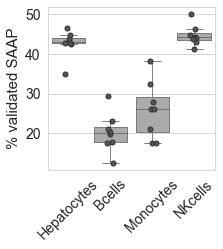

In [83]:
# generate dataframe for plot of how many candidate SAAP from Savitski DP search were validated by MSFragger 
# supp. figure 5b

cptac_saap_list = open(dependencies_dir+'unique_CPTAC_SAAP_BP_list.txt', 'r').readlines()
cptac_saap_list = [x.split('\n')[0] for x in cptac_saap_list]
cptac_saap_list = [x.split('\t') for x in cptac_saap_list]
cptac_saaps = [x[0] for x in cptac_saap_list]

ordered_timepoints = {}
for celltype in cell_types:
    cell_meta = metadata.loc[metadata['cell type']==celltype]
    timepoints = list(set(cell_meta['time point'].to_list()))
    timepoints = [str(y)+'h' for y in sorted([int(x.split('h')[0]) for x in timepoints])]
    ordered_timepoints[celltype] = timepoints
ordered_times = {k:[int(x.split('h')[0]) for x in v] for k,v in ordered_timepoints.items()}    
    

plot_rows = []
plot_cols = ['Cell type', 'Sample', '% peptides', '% type']

for celltype in cell_types:
    qmtp_dict = pickle.load(open(aa_subs_dir+'qMTP_dict_'+celltype+'.p','rb'))
    cand_seqs = list(set([x for y in list(qmtp_dict['mistranslated sequence'].values()) for x in y]))
    all_seqs = cand_seqs + cptac_saaps
    cell_df = quant_df.loc[quant_df['Cell type']==celltype]
    cell_times = ordered_times[celltype]
    reps = [1,2]

    all_val_seqs = list(set(cell_df['SAAP'].to_list()))
    for time in cell_times:
        for rep in reps:
            sample = str(time)+'_'+str(rep)
            sample_df = cell_df.loc[(cell_df['Time']==time) & (cell_df['Replicate']==rep)]
            sample_df.dropna(inplace=True, subset=['Light+Heavy SAAP intensity'])
            val_seqs = list(set(sample_df['SAAP'].to_list()))
            pcnt_sav_saap = 100*len([x for x in cand_seqs if x in val_seqs])/len(cand_seqs)
            pcnt_cptac_saap = 100*len([x for x in cptac_saaps if x in val_seqs])/len(cptac_saaps)
            pcnt_all_saap = 100*len([x for x in all_seqs if x in val_seqs])/len(all_seqs)
            plot_rows.append([celltype, sample, pcnt_sav_saap, 'Savitskit SAAP'])
            plot_rows.append([celltype, sample, pcnt_cptac_saap, 'CPTAC SAAP'])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(3,3))

plot_df = plot_df.loc[plot_df['% type']=='Savitskit SAAP']
sns.boxplot(data=plot_df, x='Cell type', y='% peptides', linewidth=0.8, fliersize=0, dodge=True, saturation=0.8, color='#AAAAAA')
sns.stripplot(data=plot_df, x='Cell type', y='% peptides', linewidth=1, dodge=True, color='#555555')
plt.yticks(fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.xlabel('')
plt.ylabel('% validated SAAP', fontsize=15)
plt.savefig(outdir+'percent_validated_boxplot.pdf', bbox_inches='tight')

### Extended data figure 2d,e,f: ionization efficiency normalization

In [92]:
# ionization efficiencies for peptides and normalization of abundances are computed in decode pipeline quant
# here read in data from MTP_quant_dict.p and plot 

all_ds_mtp_ie = []
all_ds_bp_ie = []

for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    quant_dict = pickle.load(open(data_dir+'MTP_quant_dict.p', 'rb'))

    ds_mtp_ie = []
    ds_bp_ie = []
    for q,qdict in quant_dict.items():
        ds_mtp_ie.append(qdict['IE_dict']['MTP_IE'])
        ds_bp_ie.append(qdict['IE_dict']['BP_IE'])
    all_ds_mtp_ie = all_ds_mtp_ie + ds_mtp_ie
    all_ds_bp_ie = all_ds_bp_ie + ds_bp_ie
    
# plot histogram with SAAP and BP ionization efficiencies (Ext. Data Fig. 2d)
fig,ax = plt.subplots(figsize=(4,3))
sns.histplot(all_ds_mtp_ie, alpha=0.8, label='SAAP')
sns.histplot(all_ds_bp_ie, alpha=0.5,color=colors[1], label='BP')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:])
plt.xlabel('Ionization efficiency', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'All_peptide_IE_hist.pdf', bbox_inches='tight')
plt.close()

# plot a correlation plot of SAAP to BP ionization efficiency (Ext. Data Fig. 2e)
fig,ax = plt.subplots(figsize=(4,3))
sns.scatterplot(y=all_ds_mtp_ie, x=all_ds_bp_ie, alpha=0.8, s=15, linewidth=0.5)
plt.xlabel('BP ionization efficiency', fontsize=14)
plt.ylabel('SAAP ionization efficiency', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'All_peptide_IE_corr.png', dpi=300, bbox_inches='tight')
plt.close()

# plot a distribution of the fold changes between SAAP and BP ionization efficiencies (Ext. Data Fig. 2f)
ie_fc = [all_ds_mtp_ie[i]/all_ds_bp_ie[i] for i in range(len(ds_mtp_ie))]
fig,ax=plt.subplots(figsize=(4,3))
sns.histplot(ie_fc, bins=20)
plt.xlabel('Ionization fold change', fontsize=14)
plt.ylabel('Count', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'All_saap_bp_IE_FC.pdf', bbox_inches='tight')
plt.close()

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


### Extended data figure 2a,b,c: N frags, PEP, mass error of high vs low RAAS

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


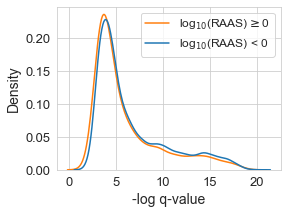

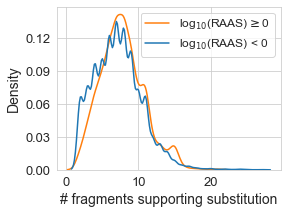

In [93]:
# Ext. Data Fig 2a,b
# generate a dictionary with PEP values and N fragments for all SAAP in all datasets 

paas_pep_dict = {}
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    samples = samples_list[datasets.index(ds)]
    mtp_dict = pickle.load(open(data_dir + 'Ion_validated_MTP_dict.p', 'rb'))
    mtp_quant_dict = pickle.load(open(data_dir + 'MTP_quant_dict.p', 'rb'))

    plot_rows = []
    plot_cols = ['Dataset', 'Sample', 'PAAS', 'PAAS_val_idx', 'DP PEP', 'PAAS PEP', 'PAAS q', 'PAAS Precursor Intensity','BP Precursor Intensity', 'Precursor RAAS', 'N fragments']
    for s in samples:
        s_dict = mtp_dict[s]
        for k, paas in s_dict['mistranslated sequence'].items():
            paas_pep = s_dict['Posterior subs probability'][k]
            paas_q = s_dict['q-value'][k]
            dp_pep = s_dict['DP PEP'][k]
            n_frags = s_dict['fragment_evidence'][k]
            q_dict = [i for i,v in mtp_quant_dict.items() if v['MTP_seq']==paas]
            if len(q_dict)>0:
                q_dict = mtp_quant_dict[q_dict[0]]
                paas_prec = q_dict['MTP_PrecInt'][s]
                bp_prec = q_dict['BP_PrecInt'][s]
                raas = q_dict['Prec_ratio'][s]
                if (~np.isnan(raas)) and (~np.isinf(raas)):
                    plot_rows.append([ds, s, paas, k, dp_pep, paas_pep, paas_q, paas_prec, bp_prec, raas, n_frags])
    plot_df = pd.DataFrame(plot_rows, columns=plot_cols)   
    paas_pep_dict[ds] = plot_df

pickle.dump(paas_pep_dict, open(outdir+'SAAP_PEP_dfs.p', 'wb'))

# create data frame for plot 
all_ds_plot_df = pd.concat([v for k,v in paas_pep_dict.items()])
all_ds_plot_df['RAAS group'] = ['$\geq$0' if raas>=0 else '<0' for i,raas in list(enumerate(all_ds_plot_df['Precursor RAAS'].values))]
all_ds_plot_df = all_ds_plot_df.loc[all_ds_plot_df['PAAS q']<=0.01]

# plot histogram of confidence values stratified by RAAS (Ext. Data Fig. 2a)
fig,ax = plt.subplots(figsize=(4,3))
all_ds_plot_df['-log q'] = [-np.log10(x) for x in all_ds_plot_df['PAAS q']]
high_raas_df = all_ds_plot_df.loc[all_ds_plot_df['Precursor RAAS']>=0]
low_raas_df = all_ds_plot_df.loc[all_ds_plot_df['Precursor RAAS']<0]
sns.kdeplot(data = high_raas_df.loc[~np.isinf(high_raas_df['-log q'])], x='-log q', fill=False, color=colors[1], label='log$_{10}$(RAAS)$\geq$0')
sns.kdeplot(data = low_raas_df.loc[~np.isinf(low_raas_df['-log q'])], x='-log q', fill=False, label='log$_{10}$(RAAS) < 0')
ax.tick_params('both', labelsize=13)
plt.ylabel('Density', fontsize=14)
plt.xlabel('-log q-value', fontsize=14)
plt.legend(fontsize=12)
plt.savefig(outdir+'RAASgroup_logq_hist.pdf', bbox_inches='tight')

# plot histogram of N fragments on substitution site stratified by RAAS (Ext. Data Fig. 2b)
fig,ax = plt.subplots(figsize=(4,3))
sns.kdeplot(data = high_raas_df.loc[~np.isinf(high_raas_df['-log q'])], x='N fragments', fill=False, color=colors[1], label='log$_{10}$(RAAS)$\geq$0')
sns.kdeplot(data = low_raas_df.loc[~np.isinf(low_raas_df['-log q'])], x='N fragments', fill=False, label='log$_{10}$(RAAS) < 0')
ax.tick_params('both', labelsize=13)
plt.ylabel('Density', fontsize=14)
plt.xlabel('# fragments supporting substitution', fontsize=14)
plt.yticks([0,0.03,0.06,0.09,0.12])
plt.legend(fontsize=12)
plt.savefig(outdir+'RAASgroup_Nfrags_hist.pdf', bbox_inches='tight')

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


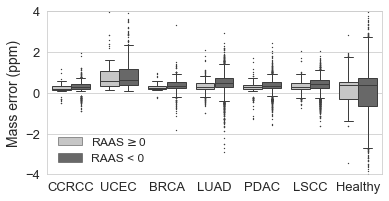

In [94]:
# Ext. Data Fig. 2c

def get_saap_mass_err(saap, s_saap_dict):
    saap_idx = [k for k,v in s_saap_dict['mistranslated sequence'].items() if v==saap]
    err = [s_saap_dict['Mass error (ppm)'][k] for k in saap_idx]
    return(np.median(err))

# create a dictionary with mass errors of SAAP with high and low RAAS
mass_err_dict = {ds:{'High RAAS mass error':[], 'Low RAAS mass error':[]} for ds in datasets}
for ds in datasets:
    data_dir = data_dir_list[datasets.index(ds)]
    ds_prec_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds]   
    saap_dict = pickle.load(open(data_dir+'Ion_validated_MTP_dict.p','rb'))
    samples = samples_list[datasets.index(ds)]
    for s in samples:
        s_saap_dict = saap_dict[s]
        if 'Mass error (ppm)' in s_saap_dict.keys():
            s_prec_df = ds_prec_df.loc[ds_prec_df['TMT/Tissue']==s]
            high_saap = s_prec_df.loc[s_prec_df['RAAS']>=0, 'SAAP'].to_list()
            low_saap = s_prec_df.loc[s_prec_df['RAAS']<0, 'SAAP'].to_list()
            high_errs = [get_saap_mass_err(saap, s_saap_dict) for saap in high_saap]
            low_errs = [get_saap_mass_err(saap, s_saap_dict) for saap in low_saap]
            mass_err_dict[ds]['High RAAS mass error']  = mass_err_dict[ds]['High RAAS mass error'] + high_errs
            mass_err_dict[ds]['Low RAAS mass error']  = mass_err_dict[ds]['Low RAAS mass error'] + low_errs 
pickle.dump(mass_err_dict, open(outdir+'High_v_low_RAAS_mass_error_ppm.p','wb'))

# create dataframe for plot
plot_df_list = []
for ds in datasets:
    print(ds)
    ds_me_dict = mass_err_dict[ds]
    high_errs = ds_me_dict['High RAAS mass error']
    low_errs = ds_me_dict['Low RAAS mass error']
    ds_list = [ds]*len(high_errs+low_errs)
    high_str_list = ['RAAS$\geq$0']*len(high_errs)
    low_str_list = ['RAAS < 0']*len(low_errs)
    ds_plot_df = pd.DataFrame(zip(ds_list, high_errs+low_errs, high_str_list+low_str_list), columns=['Dataset', 'Mass error (ppm)', 'Peptide type'])
    plot_df_list.append(ds_plot_df)
plot_df = pd.concat(plot_df_list)

# plot distributions of mass errors for SAAP with high and low RAAS 
fig,ax = plt.subplots(figsize=(6,3))
sns.boxplot(data=plot_df, x='Dataset', hue='Peptide type', y='Mass error (ppm)', linewidth=1, fliersize=0.5, palette='Greys')
plt.ylabel('Mass error (ppm)', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.xlabel('')
plt.ylim(-4,4)
plt.legend(loc='lower left', fontsize=12, frameon=False, ncol=1)
plt.savefig(outdir+'HighvLow_RAAS_Mass_error_boxplots.png', dpi=300, bbox_inches='tight')

### Figure 2c, Extended Data Figure 2g: Consistency of RAAS values for same substitution detected in different peptides/enzymatic digests


In [95]:
aa_subs_dir = wang_data_dir

tonsil_saap_dict= pickle.load(open(aa_subs_dir+'Tonsil_SAAP_dict.p','rb'))
tonsil_bp_dict= pickle.load(open(aa_subs_dir+'Tonsil_BP_dict.p','rb'))

In [97]:
other_enz_list = ['Chymotrypsin', 'LysC', 'ArgC', 'GluC']

# get list of SAAPs across digests with the same substitution (using the index in the protein sequence)
prot_aas_idx_pairs = {}
for s, sdict in tonsil_saap_dict.items():
    prot_aas_idx_pairs[s] = []
    pep_ids = sdict['Peptide IDs']
    for p,pid in pep_ids.items():
        prot_aas_idx_pairs[s].append([pid['saap_prot_fasta_idx'], pid['saap_prot_idx']])
set_prot_aas_idx_pairs = [x for y in list(prot_aas_idx_pairs.values()) for x in y if len(x)>0]
saaps_each_pair = {str(pair):[x for x,v in prot_aas_idx_pairs.items() if pair in v] for pair in set_prot_aas_idx_pairs}
saaps_each_pair = {k:v for k,v in saaps_each_pair.items() if len(v)>1}
saap_lists_w_same_aas = []
for k,v in saaps_each_pair.items():
    if v not in saap_lists_w_same_aas:
        saap_lists_w_same_aas.append(v)

# generate dataframe with RAAS values for substitutions found in multiple digests 
plot_rows = []
plot_cols = ['Trypsin RAAS', 'Other RAAS', 'Digest', 'Same sequence', 'SAAP abundance']
for s, sdict in tonsil_saap_dict.items():
    if 'Trypsin' in sdict['Digests']:
        raas_dict = sdict['RAAS']
        trypsin_raas = np.log10(2**raas_dict['Trypsin'])
        saap_abund = sdict['SAAP abundance']['Trypsin']
        # include abundance values to stratify plot by SAAP abundance 
        if saap_abund>=1e10:
            saap_abund=10
        elif saap_abund>=1e9:
            saap_abund=9
        elif saap_abund>=1e8:
            saap_abund=8
        else:
            saap_abund=7
        for enz in other_enz_list:
            if enz in sdict['Digests'] :
                same_seq = True
            if enz in raas_dict:
                raas = np.log10(2**raas_dict[enz])
                plot_rows.append([trypsin_raas, raas, enz, same_seq, saap_abund])

for saap_pair in saap_lists_w_same_aas:
    sdict1 = tonsil_saap_dict[saap_pair[0]]
    sdict2 = tonsil_saap_dict[saap_pair[1]]
    if 'Trypsin' in sdict1['Digests']:
        trypsin_raas = np.log10(2**sdict1['RAAS']['Trypsin'])
        saap_abund = sdict1['SAAP abundance']['Trypsin']
        if saap_abund>=1e10:
            saap_abund=10
        elif saap_abund>=1e9:
            saap_abund=9
        elif saap_abund>=1e8:
            saap_abund=8
        else:
            saap_abund=7
        other_dig = sdict2['Digests']
        for dig in other_dig:
            if dig!='Trypsin':
                other_raas = np.log10(2**sdict2['RAAS'][dig])
                plot_rows.append([trypsin_raas, other_raas, dig, False, saap_abund])
    elif 'Trypsin' in sdict2['Digests']:
        trypsin_raas = np.log10(2**sdict2['RAAS']['Trypsin'])        
        saap_abund = sdict2['SAAP abundance']['Trypsin']
        if saap_abund>=1e10:
            saap_abund=10
        elif saap_abund>=1e9:
            saap_abund=9
        elif saap_abund>=1e8:
            saap_abund=8
        else:
            saap_abund=7
        other_dig = sdict1['Digests']
        for dig in other_dig:
            if dig!='Trypsin':
                other_raas = np.log10(2**sdict1['RAAS'][dig])       
                plot_rows.append([trypsin_raas, other_raas, dig, False, saap_abund])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df = plot_df.replace(np.inf, np.nan)
plot_df = plot_df.replace(-np.inf, np.nan)
plot_df = plot_df.dropna()
plot_df.to_excel(outdir+'Trypsin_vs_other_digest_plot_df.xlsx')

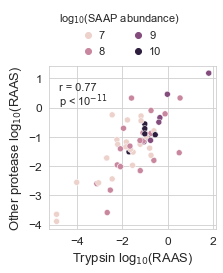

In [98]:
# plot RAAS of substitution in another digest vs RAAS of substitution in trypsin, colored by SAAP abundance
# Ext. Data Fig. 2g

sns.set_style('whitegrid')
fig,ax=plt.subplots(figsize=(3,3))
sns.scatterplot(data=plot_df, x='Trypsin RAAS', y='Other RAAS', hue='SAAP abundance')
plt.legend(loc='lower left', handletextpad=0, ncol=2, bbox_to_anchor=(0,1), frameon=False, fontsize=11, title='log$_{10}$(SAAP abundance)', title_fontsize=11)

r,p = sp.stats.pearsonr(plot_df['Trypsin RAAS'].to_list(), plot_df['Other RAAS'].to_list())
ax.text(-4.8,0.6, 'r = '+str(np.round(r, 2)), fontsize=11)
ax.text(-4.8,0.1, 'p < 10$^{-11}$', fontsize=11)

plt.ylabel('Other protease log$_{10}$(RAAS)', fontsize=13)
plt.xlabel('Trypsin log$_{10}$(RAAS)', fontsize=13)
ax.tick_params('both', labelsize=12)
plt.savefig(outdir+'tonsil_trypsinRAAS_vs_otherRAAS_scatter_saapabundcolor_newvalsearch.pdf', bbox_inches='tight')

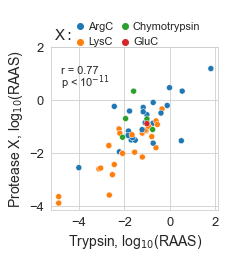

In [99]:
# plot RAAS of substitution in another digest vs RAAS of substitution in trypsin, colored by digest
# Fig. 2c

sns.set_style('whitegrid')
fig,ax=plt.subplots(figsize=(3,3))
sns.scatterplot(data=plot_df, x='Trypsin RAAS', y='Other RAAS', hue='Digest')
handles, labels = ax.get_legend_handles_labels()  
plt.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5,1.08),
           handletextpad=-0.3, ncol=2, frameon=False, fontsize=11, columnspacing=0.1)#, title='log$_{10}$(SAAP abundance)')
ax.annotate(r'X$:$', xy=(0.25,1.01), xycoords='figure fraction', fontsize=15)

r,p = sp.stats.pearsonr(plot_df['Trypsin RAAS'].to_list(), plot_df['Other RAAS'].to_list())
ax.text(-4.8,1, 'r = '+str(np.round(r, 2)), fontsize=11)
ax.text(-4.8,0.5, 'p < 10$^{-11}$', fontsize=11)
plt.yticks([-4,-2,0,2])

plt.ylabel('Protease X, log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Trypsin, log$_{10}$(RAAS)', fontsize=14)
ax.tick_params('both', labelsize=13)
plt.savefig(outdir+'tonsil_trypsinRAAS_vs_otherRAAS_scatter_digestseqcolor_newvalsearch.pdf', bbox_inches='tight')

### Extended Data FIgure 2h: Compare abundance of missed cleaved BPs to BPs without missed cleavages


In [100]:
# get data for plot from Supplemental_Data_2.SAAP_precursor_quant.xlsx

ds_bp_mc_dict = {ds:{} for ds in datasets}
for ds in datasets:
    ds_saap_df = filt_saap_df.loc[filt_saap_df['Dataset']==ds]
    bp_list_all = ds_saap_df['BP'].to_list()
    for i,row in ds_saap_df.iterrows():
        bp = row['BP']
        bp_list = [x for x in bp_list_all if x!=bp]
        mc = list(set([x for x in bp_list if bp in x]))
        if len(mc)>0:
            ds_bp_mc_dict[ds][bp] = mc
            
plot_rows = []
plot_cols = ['Dataset', 'BP', 'Missed cleavage BP', 'BP abundance', 'Missed cleavage BP abundance', 'AAS', 'AAS index', 'Color']
for ds in datasets:
    print(ds)
    ds_bp_mc = ds_bp_mc_dict[ds]
    ds_prec_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds]
    samples = samples_list[datasets.index(ds)]
    for bp, mc_list in ds_bp_mc.items():
        for s in samples:
            s_df = ds_prec_df.loc[ds_prec_df['TMT/Tissue']==s]
            for mc in mc_list:
                if bp in s_df['BP'].to_list() and mc in s_df['BP'].to_list():
                    bp_df = s_df.loc[s_df['BP']==bp]
                    bp_abund = bp_df['BP abundance'].values[0]
                    aas = bp_df['AAS'].values[0]
                    saap = bp_df['SAAP'].values[0]
                    raas = bp_df['RAAS'].values[0]
                    aas_idx = [i for i,x in enumerate(saap) if bp[i]!=x][0]
                    mc_abund = s_df.loc[s_df['BP']==mc, 'BP abundance'].values[0]
                    if raas>0:
                        c = 'RAAS>0'
                    else:
                        c = 'RAAS<0'
                    plot_rows.append([ds, bp, mc, bp_abund, mc_abund, aas, aas_idx, c])
                    
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


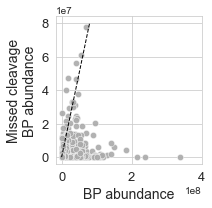

In [101]:
# plot scatterplot of abundance of BPs with missed cleavages to abundance of BPs

sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.scatterplot(data=plot_df, x='BP abundance', y='Missed cleavage BP abundance', s=40, alpha=0.9, color='#AAAAAA')
ax.tick_params('both', labelsize=13)
plt.xlabel('BP abundance', fontsize=14)
plt.ylabel('Missed cleavage\nBP abundance', fontsize=14)
plt.plot((0,8e7), (0,8e7), '--k', linewidth=1)
plt.tight_layout()
plt.xticks([0,2e8,4e8])
plt.savefig(outdir+'All_missed_cleavage_BP_vs_BP_scatter.pdf')

### Extended Data Figure 3e: Upset plot of SAAP identified across datasets

Uses Supplemental_Data_2.SAAP_proteins.xlsx (filt_saap_df)

In [102]:
import upsetplot as up
import itertools

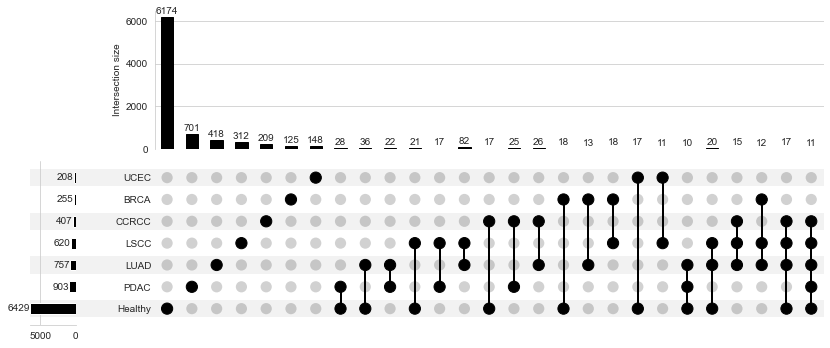

In [104]:
# get dataframe of the number of datasets each SAAP-BP pair is found in 
saap_bp = [row['SAAP']+':'+row['BP'] for i,row in filt_saap_df.iterrows()]
saap_bp_counter = Counter(saap_bp)
saap_bp_count_df = pd.DataFrame.from_dict(saap_bp_counter, columns=['N datasets'], orient='index')

def get_ds(saap, bp, filt_saap_df):
    """ function to get the list of datasets a given SAAP-BP pair is found in"""
    saap_bp_df = filt_saap_df.loc[(filt_saap_df['SAAP']==saap) & (filt_saap_df['BP']==bp)]
    ds_list = saap_bp_df['Dataset'].tolist()
    return(ds_list)

# addd column with the datasets each SAAP-BP pair is found in 
saap_bp_count_df['Datasets'] = ''
for i in saap_bp_count_df.index:
    saap = i.split(':')[0]
    bp = i.split(':')[1]
    ds_str = str(get_ds(saap, bp, filt_saap_df))
    saap_bp_count_df.loc[i,'Datasets'] = ds_str
    
# initiate index for upset plot dataframe 
l = [False, True]
arrays = [list(i) for i in itertools.product(l, repeat=7)]
arrays = np.transpose(arrays)
tuples = list(zip(*arrays))
multiindex = pd.MultiIndex.from_tuples(tuples, names=datasets)

# Create dataframe for upset plot 
saap_counts = []
idx = multiindex[1]
keepidx = []
for idx in multiindex:
    if True in idx:
        saap_ds = [datasets[i] for i,x in enumerate(idx) if x==True]
        n_saap_ds = len(saap_bp_count_df.loc[saap_bp_count_df['Datasets']==str(saap_ds)])
        if n_saap_ds>0:
            saap_counts.append(n_saap_ds)
            keepidx.append(idx)
keepidx = np.transpose(keepidx)
tuples = list(zip(*keepidx))
multiindex = pd.MultiIndex.from_tuples(tuples, names=datasets)
upset_plot_data = pd.Series(saap_counts, index=multiindex)

# plot upset plot
up.plot(upset_plot_data, show_counts=True, min_subset_size=10)
plt.savefig(outdir+'Upsetplot_n10_max_Healthy.pdf', bbox_inches='tight')

### Extended Data Figure 3f: Percentage of samples of each dataset that SAAP identified in 6+ datasets ("shared SAAP") are found in

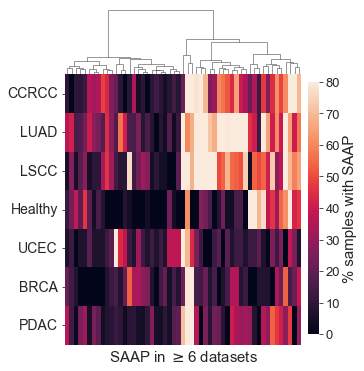

In [106]:
# add number of datasets each SAAP-BP pair is found in to data from supplemental_data_2,3,4

filt_saap_df['N datasets'] = filt_saap_df.apply(lambda x: len(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)
filt_saap_df['Datasets'] = filt_saap_df.apply(lambda x: str(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)
filt_reporter_quant_df['N datasets'] = filt_reporter_quant_df.apply(lambda x: len(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)
filt_prec_quant_df['N datasets'] = filt_prec_quant_df.apply(lambda x: len(get_ds(x['SAAP'], x['BP'], filt_saap_df)), axis=1)

# get subsets of the dataframes for which the SAAP-BP pair is found in 6+ datasets
n6_saap_df = filt_saap_df.loc[filt_saap_df['N datasets']>=6]
n6_reporter_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['N datasets']>=6]
n6_prec_df = filt_prec_quant_df.loc[filt_prec_quant_df['N datasets']>=6]

#  generate dataframe for heatmap showing in what percentage of samples does each shared saap come up in each dataset
shared_saap_bp_n6 = [i for i,row in saap_bp_count_df.iterrows() if row['N datasets']>=6]
n_samples_heatmap_df = pd.DataFrame(index=datasets, columns=shared_saap_bp_n6)
pcnt_samples_heatmap_df = pd.DataFrame(index=datasets, columns=shared_saap_bp_n6)

# dictionary with total number of samples in each dataset for computing percentages
n_total_samples_dict = {ds:0 for ds in datasets}
for ds in datasets:
    if ds != 'Healthy':
        sample_map = sample_map_list[datasets.index(ds)]
        n_total_samples = len(sample_map['sample_name'].values)
    else:
        n_total_samples = len(samples_list[datasets.index(ds)])
    n_total_samples_dict[ds] = n_total_samples
        
for saap_bp in shared_saap_bp_n6:
    saap = saap_bp.split(':')[0]
    bp = saap_bp.split(':')[1]
    for ds in datasets:
        if ds!='Healthy':
            ds_reporter_df = n6_reporter_df.loc[n6_reporter_df['Dataset']==ds]
            saap_bp_df = ds_reporter_df.loc[(ds_reporter_df['SAAP']==saap) & (ds_reporter_df['BP']==bp)]
        else:
            ds_prec_df = n6_prec_df.loc[n6_prec_df['Dataset']==ds]
            saap_bp_df = ds_prec_df.loc[(ds_prec_df['SAAP']==saap) & (ds_prec_df['BP']==bp)]
        n_samples = len(saap_bp_df)
        pcnt_samples = 100*n_samples/n_total_samples_dict[ds]
        n_samples_heatmap_df.loc[ds, saap_bp] = n_samples
        pcnt_samples_heatmap_df.loc[ds, saap_bp] = pcnt_samples
        
# plot as a heatmap
pcnt_samples_heatmap_df = pcnt_samples_heatmap_df.astype(float)
c = sns.clustermap(pcnt_samples_heatmap_df, figsize=(5,5), method='ward', xticklabels=False, vmin=0, vmax=80)
c.ax_row_dendrogram.set_visible(False)
c.ax_heatmap.set_xlabel('SAAP in $\geq$6 datasets', fontsize=15)
c.ax_heatmap.set_yticklabels(c.ax_heatmap.get_ymajorticklabels(), fontsize = 14)
c.ax_heatmap.set_facecolor('#F3F3F3')
c.ax_heatmap.yaxis.set_ticks_position('left')
c.ax_cbar.set_ylabel(r'% samples with SAAP', labelpad=3)
c.ax_cbar.set_position([0.87,0.06,0.03,0.7])
c.ax_cbar.yaxis.label.set_size(15)
c.ax_cbar.tick_params(labelsize=13)
c.savefig(outdir+'%_samples_all_ds_sharedSAAPn6_vmax80.pdf', bbox_inches='tight')

### Extended Data Figure 3g: RAAS distributions for shared SAAP (found in 6+ datasets)

Uses n6_saap_df, n6_reporter_df, n6_prec_df computed in above cell

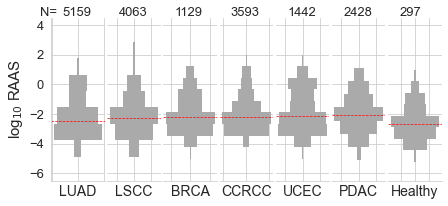

In [109]:
fig,axes = plt.subplots(1,len(datasets),figsize=(len(datasets),3), sharey=True)
plt.subplots_adjust(wspace=0.05)

sns.set_style('whitegrid')
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params('x', bottom=False,labelbottom=False)
    if ax!=axes[0]:    
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)
        
# compute medians to sort datasets by
medians = [np.nanmedian(n6_reporter_df.loc[n6_reporter_df['Dataset']==ds,'RAAS'].values) for ds in datasets[:-1]]
med_sort_idx = list(np.argsort(medians))
med_sort_idx.append(max(med_sort_idx)+1)

# plot violin plots
for i,ds in enumerate(datasets):
    ax_idx = med_sort_idx.index(i)
    axes[ax_idx].set_xlabel(ds, fontsize=14)
    if ds!='Healthy':
        ratio_data = [x for x in n6_reporter_df.loc[n6_reporter_df['Dataset']==ds,'RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    else:
        ratio_data = [x for x in n6_prec_df.loc[n6_prec_df['Dataset']==ds,'RAAS'].values if ~np.isnan(x) and ~np.isinf(x)]
    bihist(ratio_data, ratio_data, nbins=10,h=axes[ax_idx])
    if ax_idx==0:
        axes[ax_idx].annotate('N= ', (-0.2,1.01), xycoords='axes fraction', fontsize=13)

    axes[ax_idx].annotate(str(len(ratio_data)), (0.21,1.01), xycoords='axes fraction', fontsize=13)
        
    axes[ax_idx].plot(axes[ax_idx].get_xlim(), (np.median(ratio_data), np.median(ratio_data)), '--r',linewidth=0.7)

axes[0].set_ylabel(r'log$_{10}$ RAAS', fontsize=15)
axes[0].tick_params('y',labelsize=13)
axes[0].set_yticks([-6,-4,-2,0,2,4]);
plt.savefig(outdir+'Sample_level_RAAS_allDS_SharedSAAPin6.pdf', bbox_inches='tight')

### Extended Data Figure 3h: Boxplots of mean RAAS relative to LUAD

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


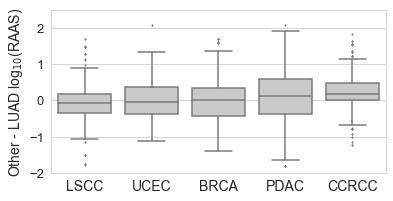

In [110]:
# initate dataframe for plot

plot_rows = []
plot_cols = ['LUAD RAAS', 'Other RAAS', 'SAAP','BP', 'LUAD-Other', 'Dataset']
for ds in datasets:
    print(ds)
    if ds != 'LUAD' and ds!='Healthy':
        luad_ds_rows = [i for i,row in filt_saap_df.iterrows() if 'LUAD' in row['Datasets'] and ds in row['Datasets']]
        luad_ds_df = filt_saap_df.loc[luad_ds_rows]
        saap_list = luad_ds_df['SAAP'].values
        bp_list = luad_ds_df['BP'].values
        
        saap_bp_list = [[saap_list[i], bp_list[i]] for i in range(len(saap_list))]
        for sb in saap_bp_list:
            saap = sb[0]
            bp = sb[1]
            sb_df = luad_ds_df.loc[(luad_ds_df['SAAP']==saap) & (luad_ds_df['BP']==bp)]
            ds_raas = sb_df.loc[sb_df['Dataset']==ds, 'Mean reporter RAAS'].values[0]
            luad_raas = sb_df.loc[sb_df['Dataset']=='LUAD', 'Mean reporter RAAS'].values[0]
            ds_luad_raas = ds_raas - luad_raas 
            plot_rows.append([luad_raas, ds_raas, saap, bp, ds_luad_raas, ds])
plot_df = pd.DataFrame(plot_rows, columns=plot_cols)

# plot data 
fig,ax = plt.subplots(figsize=(6,3))
sns.boxplot(data=plot_df, x='Dataset', y='LUAD-Other', color='#CACACA', order=['LSCC','UCEC','BRCA','PDAC','CCRCC'], fliersize=0.8)
plt.tick_params('y', labelsize=13)
plt.tick_params('x', labelsize=14)
plt.xlabel('')
plt.ylabel('Other - LUAD log$_{10}$(RAAS)', fontsize=14)
plt.ylim([-2,2.5])
plt.savefig(outdir+'Shared_SAAP_Rel2LUAD_boxplots.pdf', bbox_inches='tight')

### Figure 2e: Relative RAAS computed for shared SAAP between 2 patient samples
Analysis limited to CPTAC datasets

In [112]:
# Create a matrix with median  of relative RAAS computed for shared peptides between each pair of patients 

all_ds_matrices = {}
ds_report_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Sample type']=='Tumor']
ds_report_df.sort_values('RAAS', inplace=True)
set_samples = list(set(ds_report_df['Sample name'].values))
ds_matrix_rowcol = pd.DataFrame(index=set_samples, columns=set_samples)

for sample1 in set_samples:
    sample1_df = ds_report_df.loc[ds_report_df['Sample name']==sample1]
    sample1_saap_bp = [sample1_df['SAAP'].to_list()[i]+':'+sample1_df['BP'].to_list()[i] for i in range(len(sample1_df))]

    other_samples = set_samples[set_samples.index(sample1):]
    for sample2 in other_samples:
        sample2_df = ds_report_df.loc[ds_report_df['Sample name']==sample2]
        sample2_saap_bp = [sample2_df['SAAP'].to_list()[i]+':'+sample2_df['BP'].to_list()[i] for i in range(len(sample2_df))]
        shared_saap_bp = [x for x in sample1_saap_bp if x in sample2_saap_bp]
        row_shared_raas_ratios = []
        col_shared_raas_ratios = []
        
        # for each SAAP shared between 2 patients, compute relative RAAS on log2 scale
        for sb, saap_bp in enumerate(shared_saap_bp):
            saap = saap_bp.split(':')[0]
            bp = saap_bp.split(':')[1]
            raas1 = sample1_df.loc[(sample1_df['SAAP']==saap) & (sample1_df['BP']==bp), 'RAAS'].values[0]
            raas2 = sample2_df.loc[(sample2_df['SAAP']==saap) & (sample2_df['BP']==bp), 'RAAS'].values[0]
            if ~np.isnan(raas1) and ~np.isnan(raas2) and ~np.isinf(raas1) and ~np.isinf(raas2):
                raas_ratio = raas1 - raas2
                raas_ratio = np.log2(10**raas_ratio)
                col_raas_ratio = raas2 - raas1
                col_raas_ratio = np.log2(10**col_raas_ratio)
                row_shared_raas_ratios.append(raas_ratio)
                col_shared_raas_ratios.append(col_raas_ratio)
        ds_matrix_rowcol.loc[sample1, sample2] = np.nanmedian(row_shared_raas_ratios)
        ds_matrix_rowcol.loc[sample2, sample1] = np.nanmedian(col_shared_raas_ratios)

all_ds_matrices['All_data'] = {'Row_col':ds_matrix_rowcol}

# Add N SAAP per comparison to all_data matrix
ds_report_df = filt_reporter_quant_df.loc[filt_reporter_quant_df['Sample type']=='Tumor']
ds_report_df.sort_values('RAAS', inplace=True)
set_samples = list(set(ds_report_df['Sample name'].values))

ds_matrix_rowcol = pd.DataFrame(index=set_samples, columns=set_samples)
for i,sample1 in enumerate(set_samples):
    if i%100==0:
        print(i)
    sample1_df = ds_report_df.loc[ds_report_df['Sample name']==sample1]
    sample1_saap_bp = [sample1_df['SAAP'].to_list()[i]+':'+sample1_df['BP'].to_list()[i] for i in range(len(sample1_df))]
    other_samples = set_samples[set_samples.index(sample1):]
    for sample2 in other_samples:
        sample2_df = ds_report_df.loc[ds_report_df['Sample name']==sample2]
        sample2_saap_bp = [sample2_df['SAAP'].to_list()[i]+':'+sample2_df['BP'].to_list()[i] for i in range(len(sample2_df))]
        shared_saap_bp = [x for x in sample1_saap_bp if x in sample2_saap_bp]
        ds_matrix_rowcol.loc[sample1, sample2] = len(shared_saap_bp)
        ds_matrix_rowcol.loc[sample2, sample1] = len(shared_saap_bp)

all_ds_matrices['All_data']['N_shared_saap'] = ds_matrix_rowcol

pickle.dump(all_ds_matrices, open(outdir+'All_pairwise_sample_RAAS_ratio_matrices_log2.p', 'wb'))

0
100
200
300
400
500
600


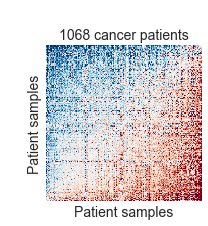

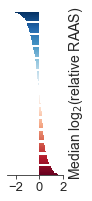

In [113]:
# plot heatmnap sorted by row/col median 
ds = 'All_data'

ds_matrix = all_ds_matrices[ds]['Row_col'].astype(float)
medians = [np.median([x for x in row.values if ~np.isnan(x)]) for i,row in ds_matrix.iterrows()]
srt_idx = np.argsort(medians)
col_medians = [np.median([x for x in ds_matrix[col].to_list() if ~np.isnan(x)]) for col in ds_matrix.columns]
col_srt_idx = np.argsort(col_medians)
plot_matrix = ds_matrix.iloc[srt_idx, col_srt_idx]

c = sns.clustermap(plot_matrix, row_cluster=False, col_cluster=False, cmap='RdBu_r', center=0, robust=True, 
                   yticklabels=False, xticklabels=False, figsize=(3,3))#, cbar_kws={'ticklocation':'left'})
c.ax_cbar.set_visible(False)
c.ax_heatmap.set_xlabel('Patient samples', fontsize=14)
c.ax_heatmap.set_ylabel('Patient samples', fontsize=14)
c.ax_heatmap.yaxis.set_label_position('left')
c.ax_heatmap.set_title('1068 cancer patients', fontsize=14)

c.savefig(outdir+ds+'_Paired_RAAS_ratios_btwn_samples_median_sorted_rowcol_log2_nocbar.pdf', bbox_inches='tight')
c.savefig(outdir+ds+'_Paired_RAAS_ratios_btwn_samples_median_sorted_rowcol_log2_nocbar.png', dpi=300, bbox_inches='tight')

medians = [np.median([x for x in row.values if ~np.isnan(x)]) for i,row in ds_matrix.iterrows()]

# barplot of patient medians
srt_medians = [medians[i] for i in srt_idx]
str_srt_idx = [str(x) for x in srt_idx]
plot_df = pd.DataFrame(zip(str_srt_idx, srt_medians), columns=['Index','Median log$_{10}$(RAAS) ratio'])

sns.set_style('ticks')
fig,ax = plt.subplots(figsize=(1,3))
sns.barplot(data=plot_df, x='Median log$_{10}$(RAAS) ratio', y='Index', palette='RdBu_r', saturation=1,linewidth=0)
ax.set_ylabel(None)
ax.set_yticks([]);
ax.tick_params('x', labelsize=13)
plt.ylabel('Median log$_{2}$(relative RAAS)', fontsize=14)
plt.xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([-2,0,2]);
ax.yaxis.set_label_position('right')
plt.savefig(outdir+ds+'_Paired_RAAS_ratios_btwn_samples_median_barplot_log2.pdf', bbox_inches='tight')

### Figure 2f: weighted means of relative RAAS for each patient in each dataset


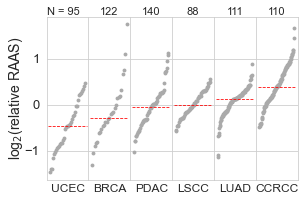

In [114]:
# plot weighted mean 

def weighted_mean(vals, ns):
    """ function to get mean weighted by the number of shared SAAP """
    wmean = np.sum([vals[i]*ns[i] for i in range(len(vals))])/np.sum(ns)
    return(wmean)

all_ds_matrix = all_ds_matrices['All_data']['Row_col'].astype(float)
all_ds_n_matrix = all_ds_matrices['All_data']['N_shared_saap'].astype(float)

sns.set_style('whitegrid')
fig,axes = plt.subplots(1, 6, figsize=(4.5,3), sharey=True)
plt.subplots_adjust(wspace=0)

# get medians for sorting datasets in plot
medians = []
for i,ds in enumerate(datasets[:-1]):
    ds_sample_map = sample_map_list[datasets.index(ds)]
    ds_samples = list(set(ds_sample_map['sample_name'].to_list()))
    ds_matrix = all_ds_matrix.loc[[r for r,row in all_ds_matrix.iterrows() if r in ds_samples]]#, [c for c in all_ds_matrix.columns if c in ds_samples]]
    n_matrix = all_ds_n_matrix.loc[[r for r,row in all_ds_n_matrix.iterrows() if r in ds_samples]]
    weighted_means = [weighted_mean(ds_matrix.loc[r], row) for r,row in n_matrix.iterrows()]
    vals = [x for x in weighted_means  if ~np.isnan(x)]
    medians.append(np.median(vals))
srt_idx = np.argsort(medians)
ds_sorted = [datasets[:-1][i] for i in srt_idx]

# plot weighted means 
for i,ds in enumerate(ds_sorted):
    ax = axes[i]
    ds_sample_map = sample_map_list[datasets.index(ds)]
    ds_samples = list(set(ds_sample_map['sample_name'].to_list()))
    ds_matrix = all_ds_matrix.loc[[r for r,row in all_ds_matrix.iterrows() if r in ds_samples]]#, [c for c in all_ds_matrix.columns if c in ds_samples]]
    n_matrix = all_ds_n_matrix.loc[[r for r,row in all_ds_n_matrix.iterrows() if r in ds_samples]]
    
    weighted_means = [weighted_mean(ds_matrix.loc[r], row) for r,row in n_matrix.iterrows()]
    vals = weighted_means
    srt_idx = np.argsort(vals)
    srt_vals = [vals[s] for s in srt_idx]
    plot_df = pd.DataFrame(zip(list(range(len(vals))), srt_vals), columns=['Rank', 'RAAS ratio'])

    sns.scatterplot(data=plot_df, y='RAAS ratio', x='Rank', ax=ax, linewidth=0, s=15, color='#AAAAAA')
    ax.set_xlabel(ds, fontsize=12)
    ax.set_xticks([])
    n = len(srt_vals)
    if i == 0:
        ax.annotate('N = '+str(int(np.round(n, 0))), xy=(0.8,1.01), xycoords='axes fraction', ha='right', fontsize=11)
    else:
        ax.annotate(str(int(np.round(n, 0))), xy=(0.5,1.01), xycoords='axes fraction', ha='center', fontsize=11)
    median = np.median([x for x in vals if ~np.isnan(x)])
    ax.plot(ax.get_xlim(), (median,median), '--r', linewidth=0.8)
    
axes[0].set_yticks([-1, 0, 1])
axes[0].tick_params('y', labelsize=13)
axes[0].set_ylabel('log$_{2}$(relative RAAS)', fontsize=14, labelpad=-0.5)

plt.savefig(outdir+'All_Paired_RAAS_ratios_btwn_samples_ranksort_allVals_log2_ds_numerator_allotherds_denom_weighted_mean.pdf', bbox_inches='tight')

### Figure 2h. SAAP  copy number estimates 

In [115]:
# compute the abundance of core histone proteins using precursor ion intensity summed over isoforms mapping to each core histone

histone_prot_abund_dict = {}
for ds in datasets:
    print(ds)
    data_dir = data_dir_list[datasets.index(ds)]
    
    # prot_dict and blast_map are computed as downstream part of decode pipeline. Provided in Google Drive. 
    prot_dict = pickle.load(open(data_dir+'Allprot_normalized_abundance_dict.p', 'rb'))
    blast_map = pd.read_excel(data_dir+'blast_map_w_gene.xlsx', index_col=0)
    samples = samples_list[datasets.index(ds)]

    histone1_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H1', row['Blast protein'])]
    histone1_proteins = blast_map.loc[histone1_protein_rows, 'Protein name'].to_list()
    histone2_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H2', row['Blast protein'])]
    histone2_proteins = blast_map.loc[histone2_protein_rows, 'Protein name'].to_list()
    histone3_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H3', row['Blast protein'])]
    histone3_proteins = blast_map.loc[histone3_protein_rows, 'Protein name'].to_list()
    histone4_protein_rows = [i for i,row in blast_map.iterrows() if re.search('histone H4', row['Blast protein'])]
    histone4_proteins = blast_map.loc[histone4_protein_rows, 'Protein name'].to_list()

    # dict of total histone protein abundance in each patient sample
    histone_prot_abund_dict[ds] = {}
    for s in samples:
        prot_df = prot_dict[s]
        histone1_prots = prot_df.loc[[x for x in histone1_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone2_prots = prot_df.loc[[x for x in histone2_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone3_prots = prot_df.loc[[x for x in histone3_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone4_prots = prot_df.loc[[x for x in histone4_proteins if x in prot_df.index], 'Precursor intensity'].sum()
        histone_prot_abund_dict[ds][s] = np.median([histone1_prots, histone2_prots, histone3_prots, histone4_prots])

pickle.dump(histone_prot_abund_dict, open(outdir+'Histone_prot_median_precursor_abundance_dict_sumsubtypes.p','wb'))

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


In [116]:
# compute copy number estimates for SAAP based on their protein abundances and histone abundances
# uses "histone ruler" method assuming 30e6 copy number for histone proteins

plot_rows = []
plot_cols = ['Dataset', 'SAAP', 'Sample name', 'SAAP abundance', 'Histone abundance', 'SAAP/Histone']
for ds in datasets:
    print(ds)
    ds_quant_df = filt_prec_quant_df.loc[filt_prec_quant_df['Dataset']==ds]
    saaps = list(set(ds_quant_df['SAAP'].values))
    samples = list(set(ds_quant_df['TMT/Tissue'].values))
    samples = [x for x in samples if x!='tonsil']

    for sample in samples:
        histone_abund = histone_prot_abund_dict[ds][sample]
        for saap in saaps:
            saap_abund = ds_quant_df.loc[(ds_quant_df['SAAP']==saap) & (ds_quant_df['TMT/Tissue']==sample), 'SAAP abundance'].values
            if len(saap_abund)>0: # not all SAAP in every sample
                saap_abund = saap_abund[0]
                saap_histone = saap_abund/histone_abund
                plot_rows.append([ds, saap, sample, saap_abund, histone_abund, saap_histone])

plot_df = pd.DataFrame(plot_rows, columns=plot_cols)
plot_df['SAAP copies'] = plot_df.apply(lambda x: np.round(30e6*x['SAAP/Histone']), axis=1)
plot_df.to_excel(outdir+'SAAP_copy_estimate_by_median_histone_sumsubtypes_precursors.xlsx')

CCRCC
UCEC
BRCA
LUAD
PDAC
LSCC
Healthy


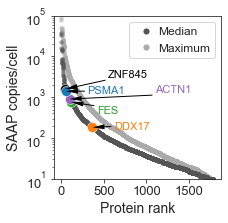

In [121]:
# plot median and max SAAP copy numbers in rank sorted order, highlighting substituted proteins of interest
prec_saap_copy_number_df = plot_df
genes = []
pfam = []
refprot = []

for i,row in prec_saap_copy_number_df.iterrows():
    ds = row['Dataset']
    saap = row['SAAP']
    prot_row = filt_saap_df.loc[(filt_saap_df['Dataset']==ds) & (filt_saap_df['SAAP']==saap)]
    if len(prot_row)>0:
        genes.append(prot_row['Genes'].values[0])
        pfam.append(prot_row['Pfam domains'].values[0])
        refprot.append(prot_row['Reference protein (blast)'].values[0])
    else:
        genes.append('')
        pfam.append('')
        refprot.append('')

prec_saap_copy_number_df['Genes'] = genes
prec_saap_copy_number_df['Pfam'] = pfam
prec_saap_copy_number_df['RefProt'] = refprot

# combine peptides across all datasets with median and max
rows = []
cols = ['SAAP', 'Median SAAP copies', 'Genes','Pfam', 'RefProt', 'Max SAAP copies']
ds_df = prec_saap_copy_number_df.loc[prec_saap_copy_number_df['Dataset']!='Healthy']
ds_saap = list(set(ds_df['SAAP'].to_list()))
for saap in ds_saap:
    saap_df = ds_df.loc[ds_df['SAAP']==saap]
    median_copies = saap_df['SAAP copies'].median()
    max_copies = saap_df['SAAP copies'].max()
    genes = saap_df['Genes'].to_list()[0]
    pfam = saap_df['Pfam'].to_list()[0]
    refprot = saap_df['RefProt'].to_list()[0]
    rows.append([saap, median_copies, genes, pfam, refprot, max_copies]) 
median_prec_saap_copy_number_df = pd.DataFrame(rows, columns=cols)

# generate plot 
rank_df = median_prec_saap_copy_number_df.loc[median_prec_saap_copy_number_df['Median SAAP copies']>=10, ['SAAP','Median SAAP copies', 'Max SAAP copies']]

sns.set_style('ticks')
fig,ax = plt.subplots(figsize=(3,3))
rank_df.sort_values('Max SAAP copies', ascending=False, inplace=True)
rank_df.reset_index(inplace=True, drop=True)
rank_df['Rank'] = rank_df.index
sns.scatterplot(data=rank_df, x='Rank', y='Max SAAP copies', color='#AAAAAA', linewidth=0, s=80, marker='.', alpha=0.5)

rank_df.sort_values('Median SAAP copies', ascending=False, inplace=True)
rank_df.reset_index(inplace=True, drop=True)
rank_df['Rank'] = rank_df.index

sns.scatterplot(data=rank_df, x='Rank', y='Median SAAP copies', color='#555555', linewidth=0, s=80, marker='.', alpha=0.5)
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='ADNTLVAYK'], x='Rank', y='Median SAAP copies', color=colors[2], linewidth=0.5, s=100)#, label='FES')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='LIDLLESGK'], x='Rank', y='Median SAAP copies', color=colors[1], linewidth=0.5, s=100)#, label='DDX17')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='VLAVNQEHEQLMEDYEK'], x='Rank', y='Median SAAP copies', color=colors[4], linewidth=0.5, s=100)#, label='DDX17')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='IIHLGGK'], x='Rank', y='Median SAAP copies', color='k', linewidth=0.5, s=100)#, label='DDX17')
sns.scatterplot(data=rank_df.loc[rank_df['SAAP']=='AGSELAAHQK'], x='Rank', y='Median SAAP copies', color=colors[0], linewidth=0.5, s=100)#, label='PSMA1')

saap2plot = ['ADNTLVAYK', 'LIDLLESGK', 'VLAVNQEHEQLMEDYEK', 'IIHLGGK', 'AGSELAAHQK']
ranks2plot = [rank_df.loc[rank_df['SAAP']==saap, 'Rank'].values[0] for saap in saap2plot]
texts2plot = ['FES','DDX17', 'ACTN1', 'ZNF845', 'PSMA1']
colors2plot = [colors[2], colors[1], colors[4], 'black', colors[0]]
for i,rank in enumerate(ranks2plot):
    txt = texts2plot[i]
    y = rank_df.loc[rank_df['Rank']==rank,'Median SAAP copies']
    if txt=='DDX17' or txt=='PSMA1':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+250,y+10), xycoords='data', textcoords='data', va='center',
                arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
    elif txt=='ZNF845':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+500,y+2000), xycoords='data', textcoords='data', va='center',
            arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
    elif txt=='ACTN1':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+1000,y+600), xycoords='data', textcoords='data', va='center',
                arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
    elif txt=='FES':
        ax.annotate(txt, xy=(rank,y), xytext=(rank+300,y-300), xycoords='data', textcoords='data', va='center',
                arrowprops=dict(facecolor='k', headwidth=5,width=1, linewidth=0), color=colors2plot[i], fontsize=11)
        
plt.ylim([10,1e5])
plt.yscale('log')
ax.tick_params('both', labelsize=13)
plt.ylabel('SAAP copies/cell', fontsize=14)
plt.xlabel('Protein rank', fontsize=14)
handles = [Line2D([0],[0], marker='o', color='w', label='Median', markerfacecolor='#555555'),
          Line2D([0],[0], marker='o', color='w', label='Maximum', markerfacecolor='#AAAAAA')]
plt.legend(handles=handles, fontsize=12, handletextpad=0, markerscale=1.2, frameon=True)
plt.savefig(outdir+'SAAP_copies_median_histone_sumsubtypes_rankplot_ticks_gr10copies_noHealthy_PSMA1_w_max.pdf', bbox_inches='tight')

### Figure 2j and Extended Data Figure 3k: RAAS vs. codon usage metrics

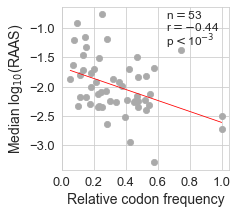

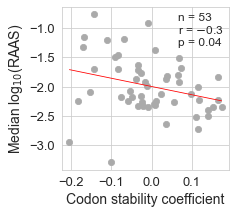

In [123]:
codon_freq = pd.read_table(dependencies_dir+'codon_frequencies.txt')


sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.regplot(data=codon_freq, y='RAAS', x='frequency_all', color='#AAAAAA', ci=False, 
            line_kws={'color':'r', 'linewidth':0.8}, scatter_kws={'s':40, 'alpha':1, 'linewidth':0.7})
ax.tick_params('both', labelsize=13)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Relative codon frequency', fontsize=14)
plt.xticks([0,0.2,0.4,0.6,0.8,1]);

# values were computed with sp.stats.pearson and then annotated manually
codon_freq_nonan = codon_freq.dropna(how='any')
r,p = sp.stats.pearsonr(codon_freq_nonan['RAAS'].values, codon_freq_nonan['frequency_all'].values)
ax.text(0.65,-0.83, r'n$=$53', fontsize=12)
ax.text(0.65,-1.05, r'r$=$$-$0.44', fontsize=12)
ax.text(0.65,-1.3, r'p$<$10$^{-3}$', fontsize=12)

plt.savefig(outdir+'codon_frequencies.pdf', bbox_inches='tight')



sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(3,3))
sns.regplot(data=codon_freq, y='RAAS', x='293T_endo', color='#AAAAAA', ci=False, 
            line_kws={'color':'r', 'linewidth':0.8}, scatter_kws={'s':40, 'alpha':1, 'linewidth':0.7})
ax.tick_params('both', labelsize=13)
plt.ylabel('Median log$_{10}$(RAAS)', fontsize=14)
plt.xlabel('Codon stability coefficient', fontsize=14)
plt.xticks([-0.2,-0.1,0,0.1]);

# values were computed with sp.stats.pearson and then annotated manually
r,p = sp.stats.pearsonr(codon_freq_nonan['RAAS'].values, codon_freq_nonan['293T_endo'].values)
ax.text(0.065,-0.87, r'n = 53', fontsize=12)
ax.text(0.065,-1.1, r'r = $-$0.3', fontsize=12)
ax.text(0.065,-1.3, r'p = 0.04', fontsize=12)


plt.savefig(outdir+'codon_stabilities.pdf', bbox_inches='tight')